#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier



* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/5_mini/2023.04.12_미니프로젝트5차_3_5일차 실습자료/data01_train.csv")

In [5]:
features = pd.read_csv("/content/drive/MyDrive/5_mini/2023.04.12_미니프로젝트5차_3_5일차 실습자료/features_fixed.csv")

In [6]:
data = data.drop("subject",axis=1)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [7]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [8]:
features

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y
...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [9]:
data["Activity"].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [10]:
data["Activity"].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [11]:
data["Activity"].value_counts()/5881

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [15]:
a=features.groupby("sensor")
for i,j in a.groups.items():
    print(i,":",end=" ")
    print(len(j))
print("총 :",len(a))

angle : 7
fBodyAcc : 79
fBodyAccJerk : 79
fBodyAccMag : 13
fBodyBodyAccJerkMag : 13
fBodyBodyGyroJerkMag : 13
fBodyBodyGyroMag : 13
fBodyGyro : 79
tBodyAcc : 40
tBodyAccJerk : 40
tBodyAccJerkMag : 13
tBodyAccMag : 13
tBodyGyro : 40
tBodyGyroJerk : 40
tBodyGyroJerkMag : 13
tBodyGyroMag : 13
tGravityAcc : 40
tGravityAccMag : 13
총 : 18


In [16]:
a=features.groupby("agg")
for i,j in a.groups.items():
    print(i,":",end=" ")
    print(len(j))
print("총 :",len(a))

X : 1
Y : 1
Z : 1
arCoeff() : 60
arCoeff()1 : 5
arCoeff()2 : 5
arCoeff()3 : 5
arCoeff()4 : 5
bandsEnergy() : 126
correlation() : 15
energy() : 33
entropy() : 33
iqr() : 33
kurtosis() : 13
mad() : 33
max() : 33
maxInds : 13
mean() : 33
meanFreq() : 13
min() : 33
skewness() : 13
sma() : 17
std() : 33
tBodyAccJerkMean : 1
tBodyAccMean : 1
tBodyGyroJerkMean : 1
tBodyGyroMean : 1
총 : 27


In [17]:
a=features.groupby("axis")
for i,j in a.groups.items():
    print(i,":",end=" ")
    print(len(j))
print("총 :",len(a))

1,16 : 3
1,16.1 : 3
1,16.2 : 3
1,24 : 3
1,24.1 : 3
1,24.2 : 3
1,8 : 3
1,8.1 : 3
1,8.2 : 3
17,24 : 3
17,24.1 : 3
17,24.2 : 3
17,32 : 3
17,32.1 : 3
17,32.2 : 3
25,32 : 3
25,32.1 : 3
25,32.2 : 3
25,48 : 3
25,48.1 : 3
25,48.2 : 3
33,40 : 3
33,40.1 : 3
33,40.2 : 3
33,48 : 3
33,48.1 : 3
33,48.2 : 3
41,48 : 3
41,48.1 : 3
41,48.2 : 3
49,56 : 3
49,56.1 : 3
49,56.2 : 3
49,64 : 3
49,64.1 : 3
49,64.2 : 3
57,64 : 3
57,64.1 : 3
57,64.2 : 3
9,16 : 3
9,16.1 : 3
9,16.2 : 3
X : 76
X,1 : 5
X,2 : 5
X,3 : 5
X,4 : 5
X,Y : 5
X,Z : 5
Y : 76
Y,1 : 5
Y,2 : 5
Y,3 : 5
Y,4 : 5
Y,Z : 5
Z : 76
Z,1 : 5
Z,2 : 5
Z,3 : 5
Z,4 : 5
gravity : 1
gravityMean : 6
총 : 62


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [18]:
from sklearn.model_selection import train_test_split
x = data.drop("Activity",axis=1)
y = data["Activity"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [19]:
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [20]:
y_pred = model.predict(x_test)
y_pred

array(['LAYING', 'SITTING', 'WALKING', ..., 'WALKING_UPSTAIRS',
       'STANDING', 'WALKING'], dtype=object)

In [21]:
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred,average="macro"))
print(confusion_matrix(y_test,y_pred))

0.9787595581988106
0.979192061561679
[[223   0   0   0   0   0]
 [  0 197   8   0   0   1]
 [  0  10 208   0   0   0]
 [  0   0   0 196   3   1]
 [  0   0   0   0 156   2]
 [  0   0   0   0   0 172]]


,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.036467
1,"angle(X,gravityMean)",0.029993
2,tGravityAcc-min()-X,0.026871
3,tGravityAcc-mean()-X,0.026578
4,tGravityAcc-max()-Y,0.025537
5,tGravityAcc-mean()-Y,0.025038
6,"angle(Y,gravityMean)",0.024766
7,tGravityAcc-max()-X,0.022203
8,tGravityAcc-min()-Y,0.020824
9,tBodyAccJerkMag-sma(),0.014350


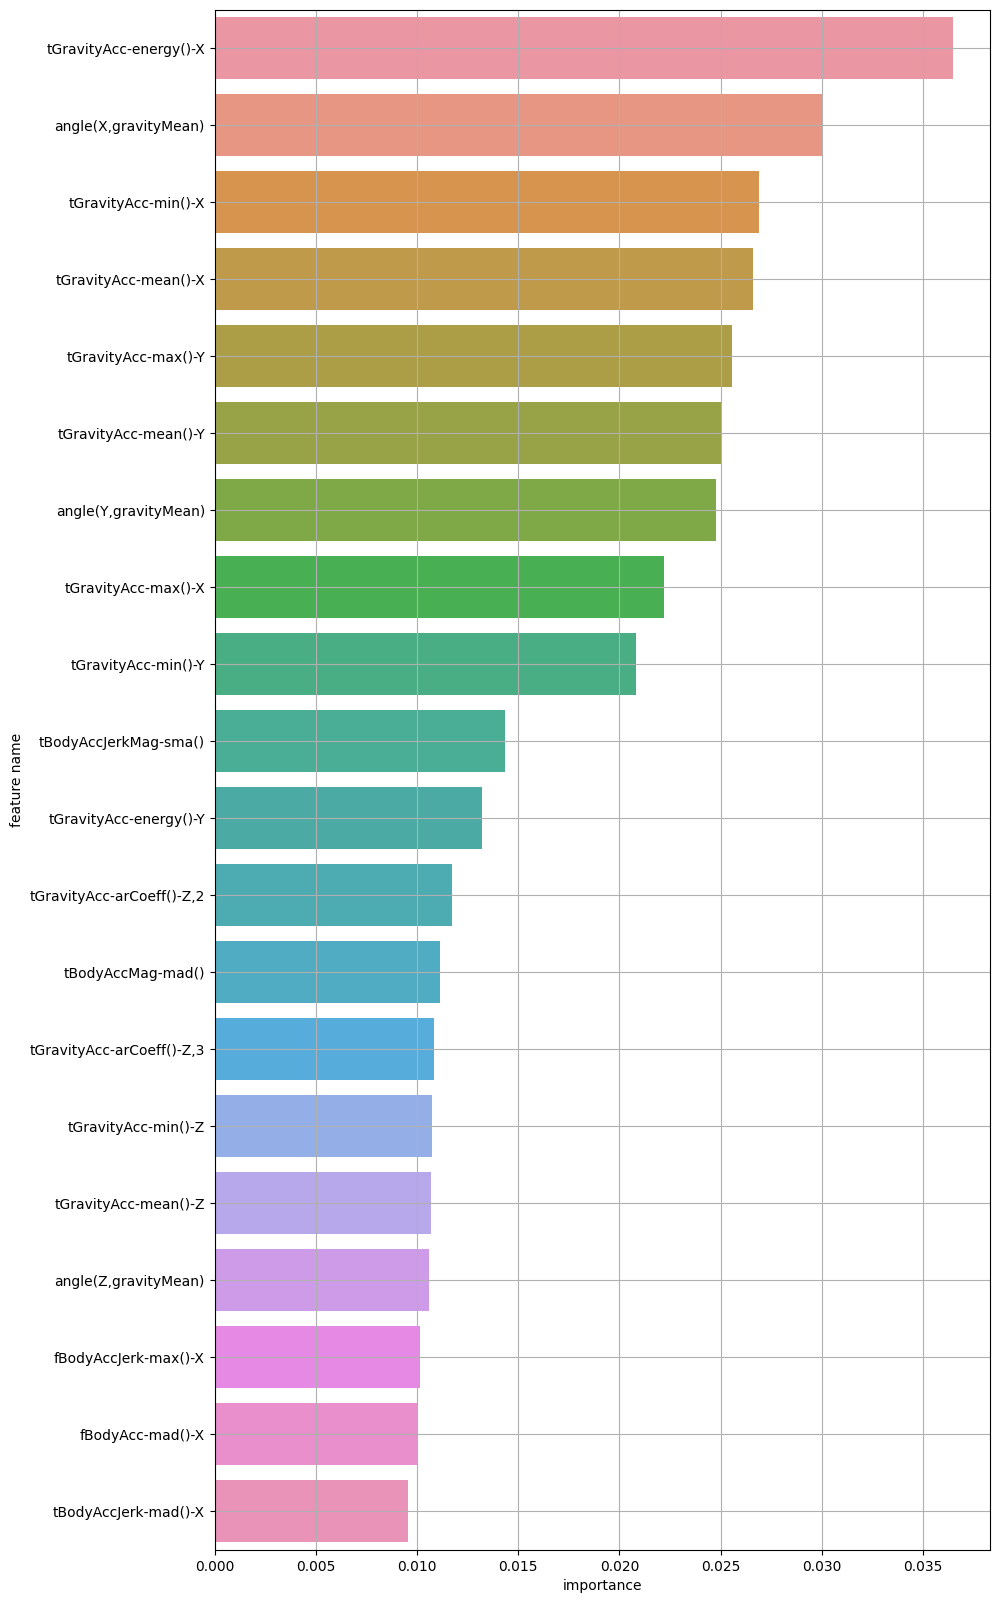

In [22]:
plot_feature_importance(model.feature_importances_,x_train.columns,result_only = False, topn =20)

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [23]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.036467
1,"angle(X,gravityMean)",0.029993
2,tGravityAcc-min()-X,0.026871
3,tGravityAcc-mean()-X,0.026578
4,tGravityAcc-max()-Y,0.025537
...,...,...
556,"fBodyAccJerk-bandsEnergy()-49,56",0.000083
557,"fBodyAccJerk-bandsEnergy()-49,56.1",0.000080
558,tBodyGyroJerk-entropy()-Y,0.000079
559,"fBodyGyro-bandsEnergy()-57,64.1",0.000059


In [ ]:
a=list(fi_temp.loc[:21,'feature_name'])
a

['tGravityAcc-mean()-Y',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-min()-Y',
 'angle(X,gravityMean)',
 'tGravityAcc-max()-Y',
 'tGravityAcc-max()-X',
 'angle(Y,gravityMean)',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Y',
 'tBodyAccJerk-std()-X',
 'fBodyAccMag-energy()',
 'fBodyAccJerk-entropy()-X',
 'tBodyAccMag-mad()',
 'fBodyAccJerk-bandsEnergy()-1,16',
 'tGravityAcc-arCoeff()-Y,1',
 'fBodyAccJerk-mad()-X',
 'tGravityAcc-arCoeff()-Z,2',
 'fBodyAccMag-mad()',
 'fBodyAccJerk-max()-X',
 'fBodyAccJerk-bandsEnergy()-1,8',
 'tGravityAcc-min()-Z']

In [ ]:
b=list(fi_temp.loc[541:,'feature_name'])

In [ ]:
target = "Activity"
for i in a:
    print(i)
    plt.figure(figsize=(18,8))
    sns.kdeplot(data=data,x=i,hue=target,common_norm=False,fill=True)
    plt.show()
    print("-----------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

fBodyAccJerk-bandsEnergy()-41,48.1


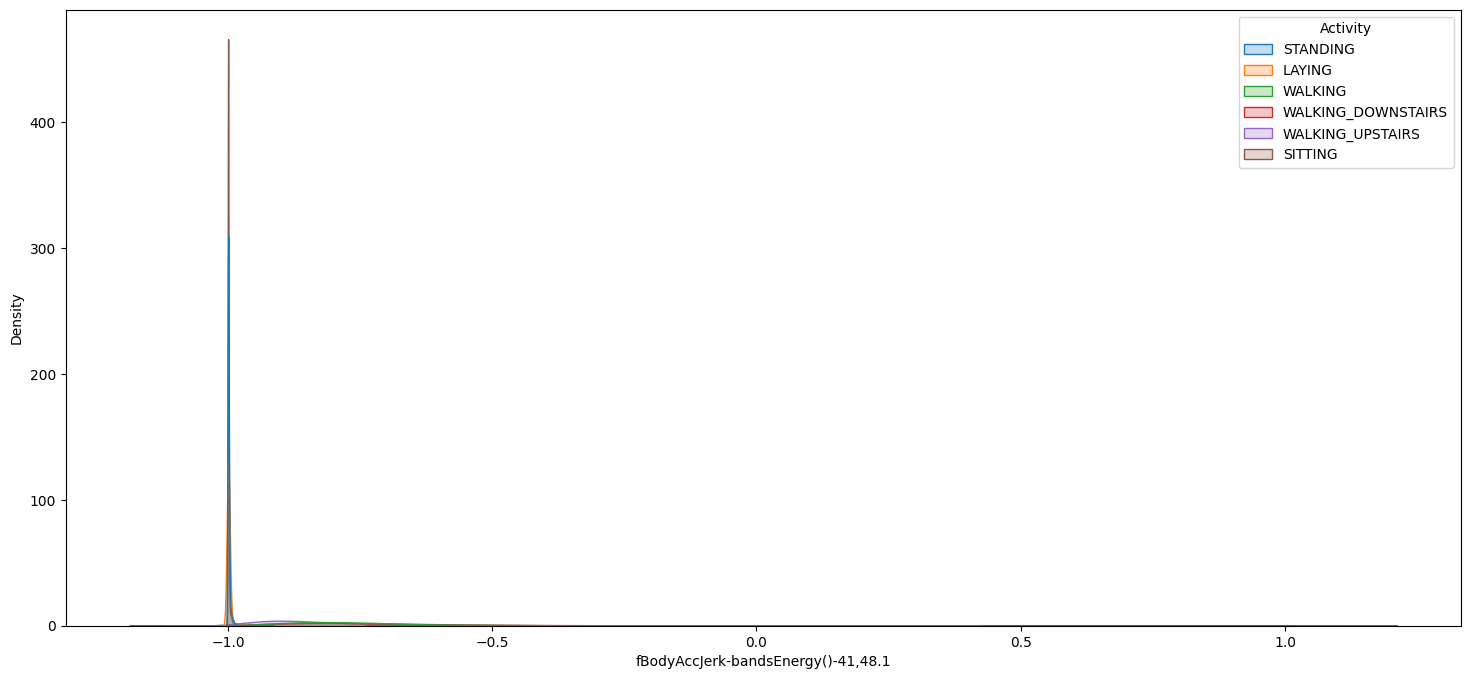

-----------------------------------------------
fBodyAccJerk-bandsEnergy()-49,56.1


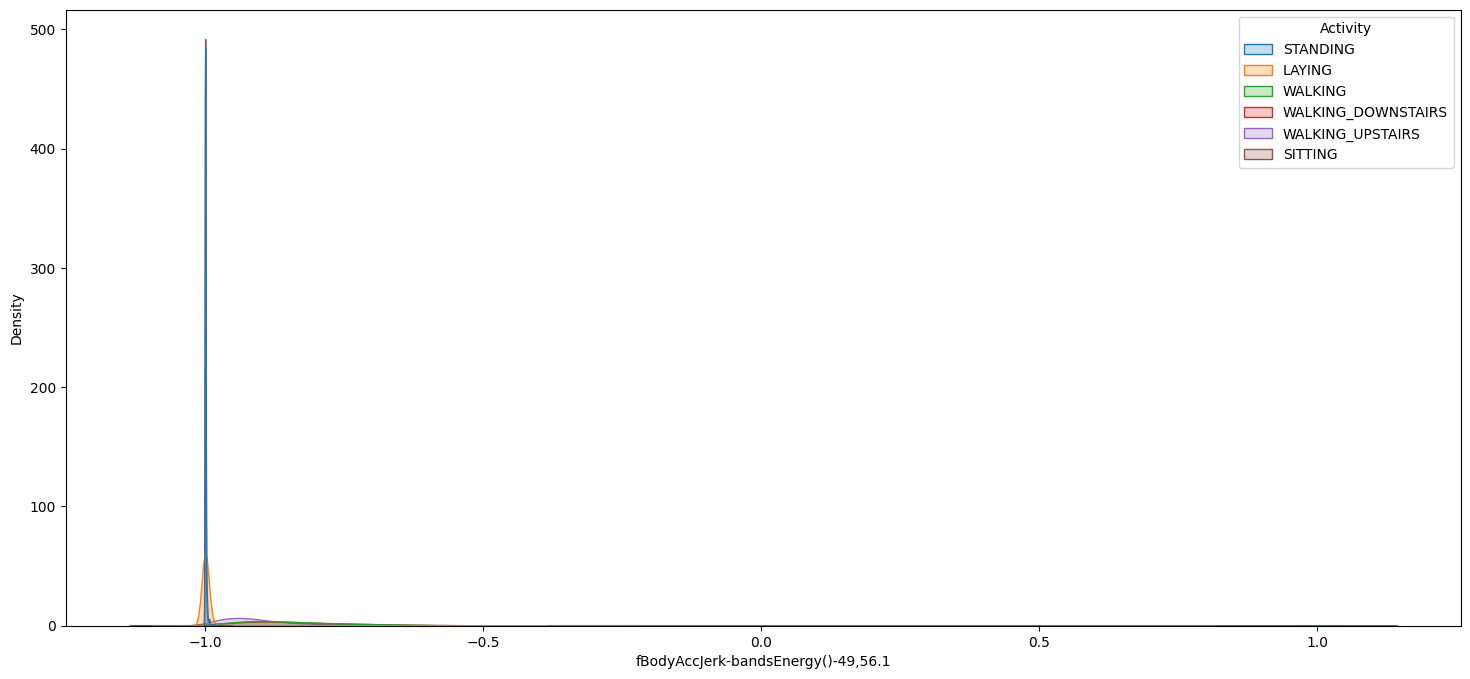

-----------------------------------------------
fBodyAccJerk-bandsEnergy()-33,40.1


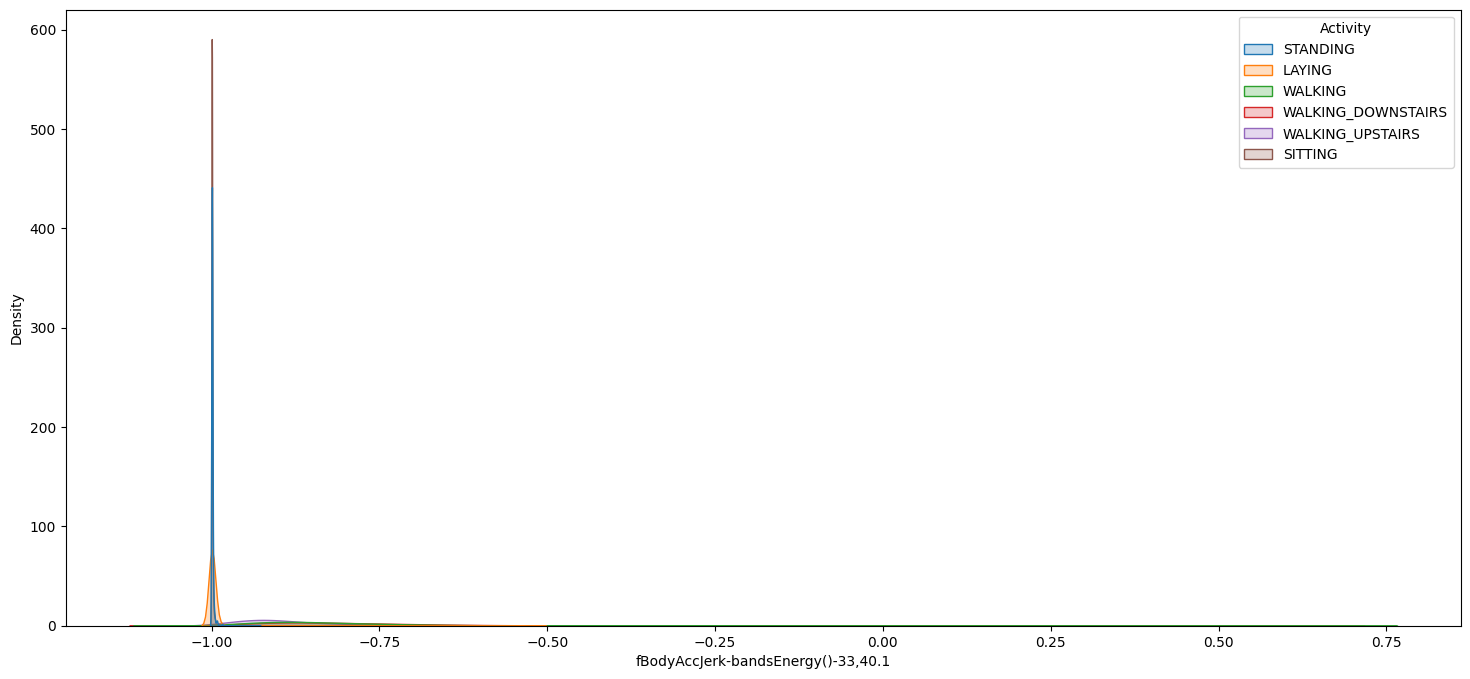

-----------------------------------------------
fBodyBodyAccJerkMag-maxInds


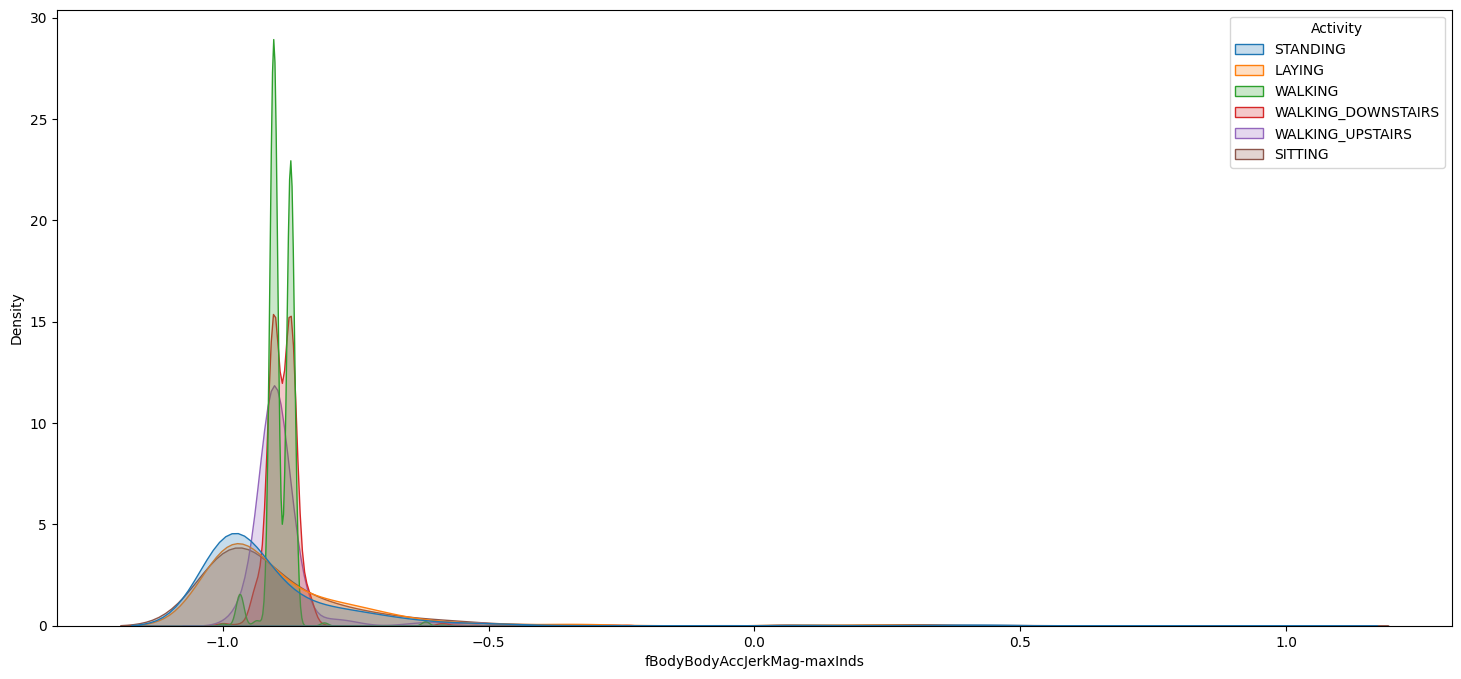

-----------------------------------------------
tBodyAccJerk-mean()-Y


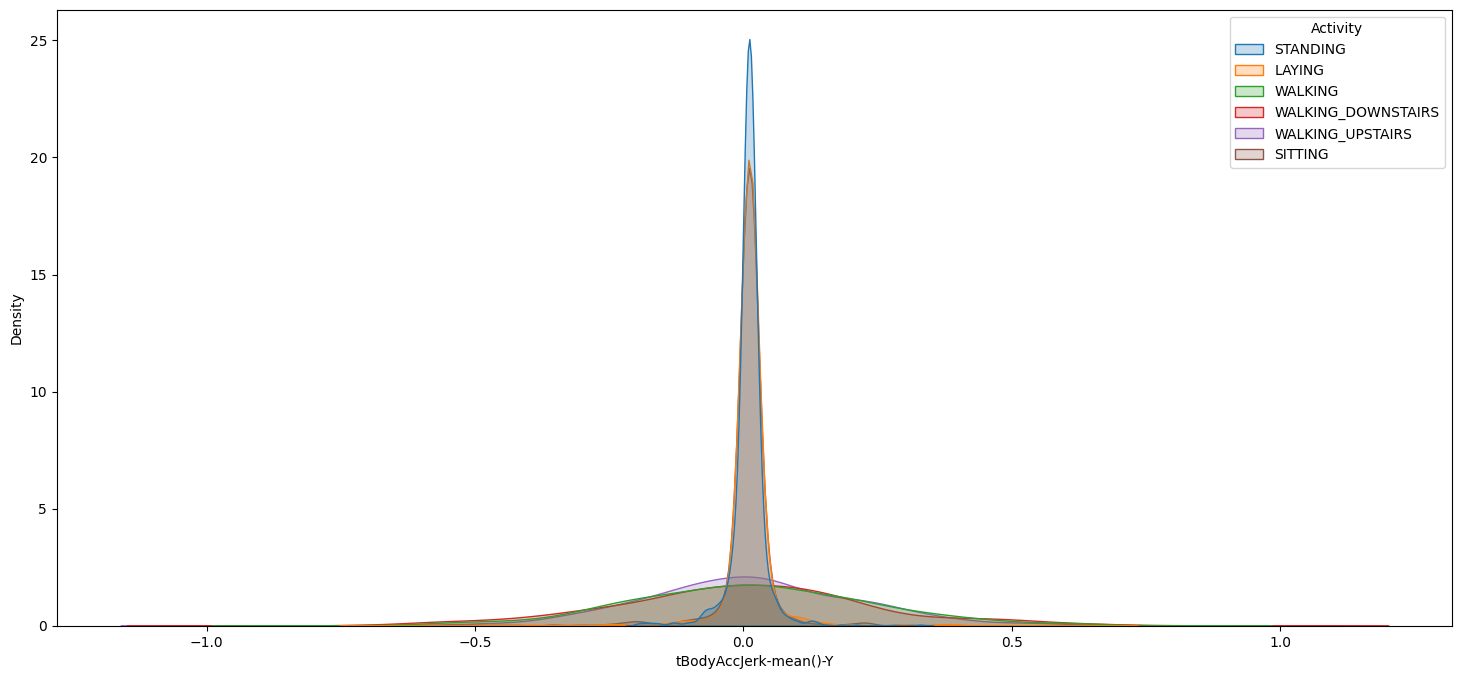

-----------------------------------------------
fBodyBodyGyroJerkMag-iqr()


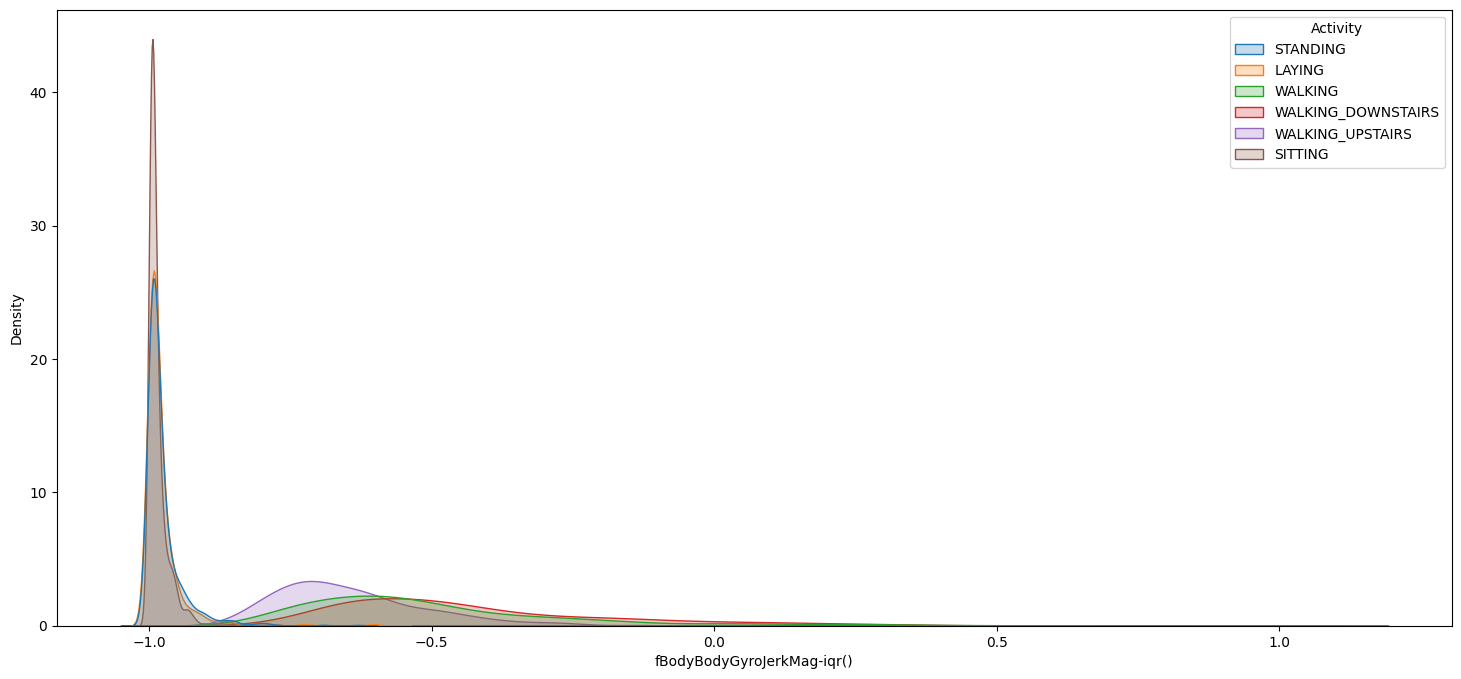

-----------------------------------------------
fBodyBodyGyroJerkMag-mean()


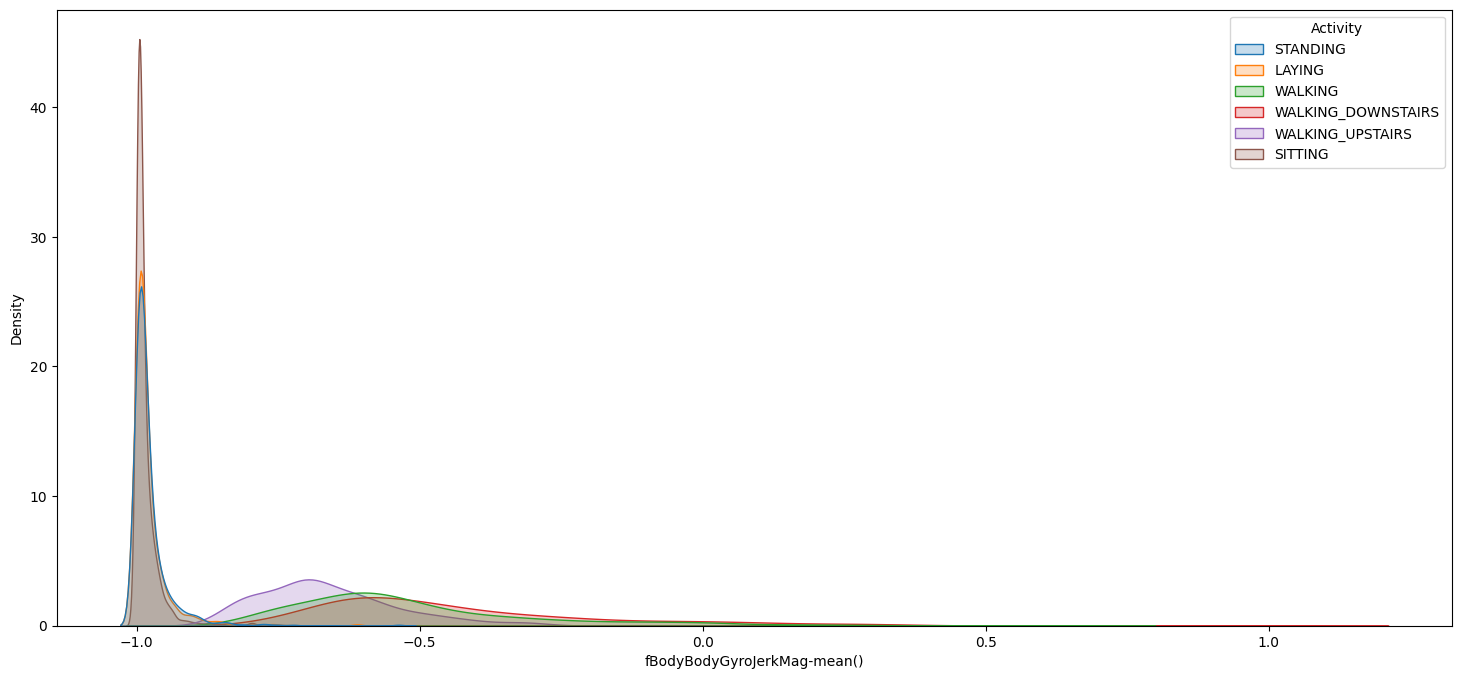

-----------------------------------------------
fBodyAccJerk-bandsEnergy()-57,64.2


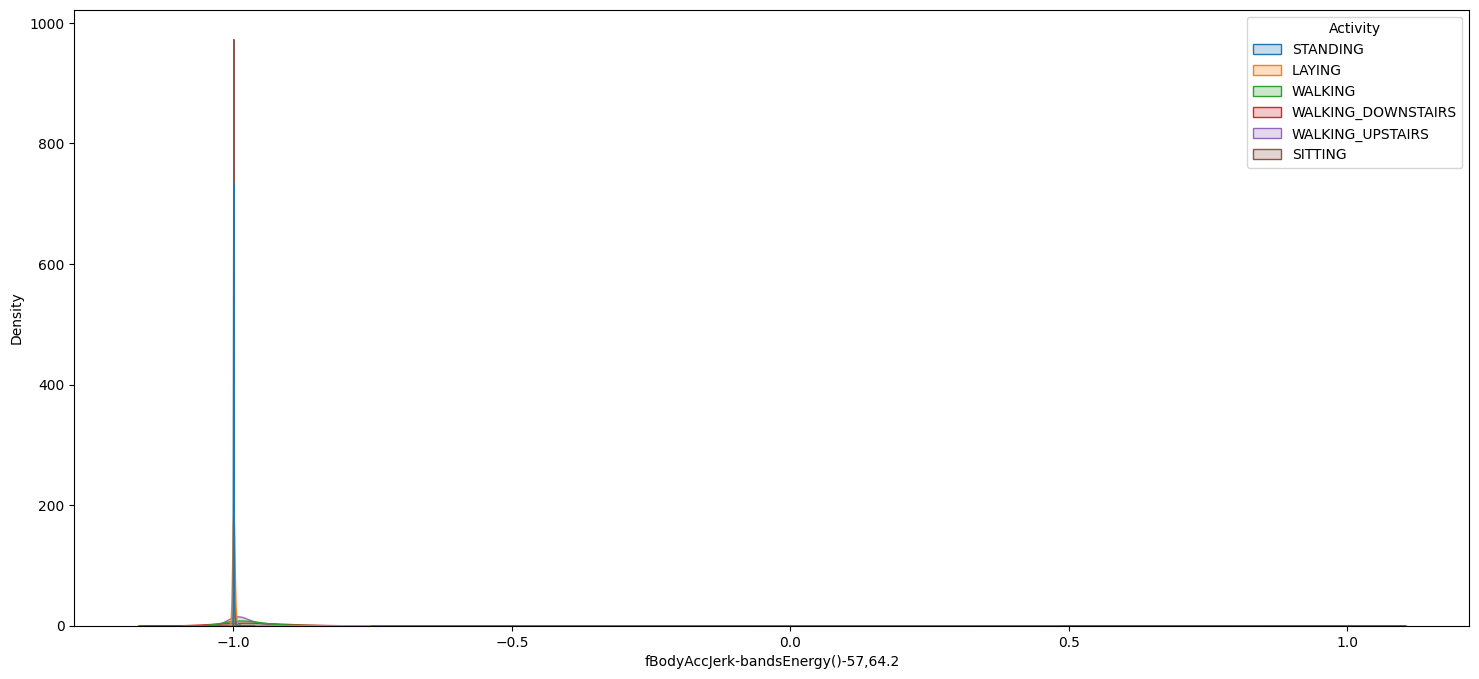

-----------------------------------------------
fBodyAcc-iqr()-Y


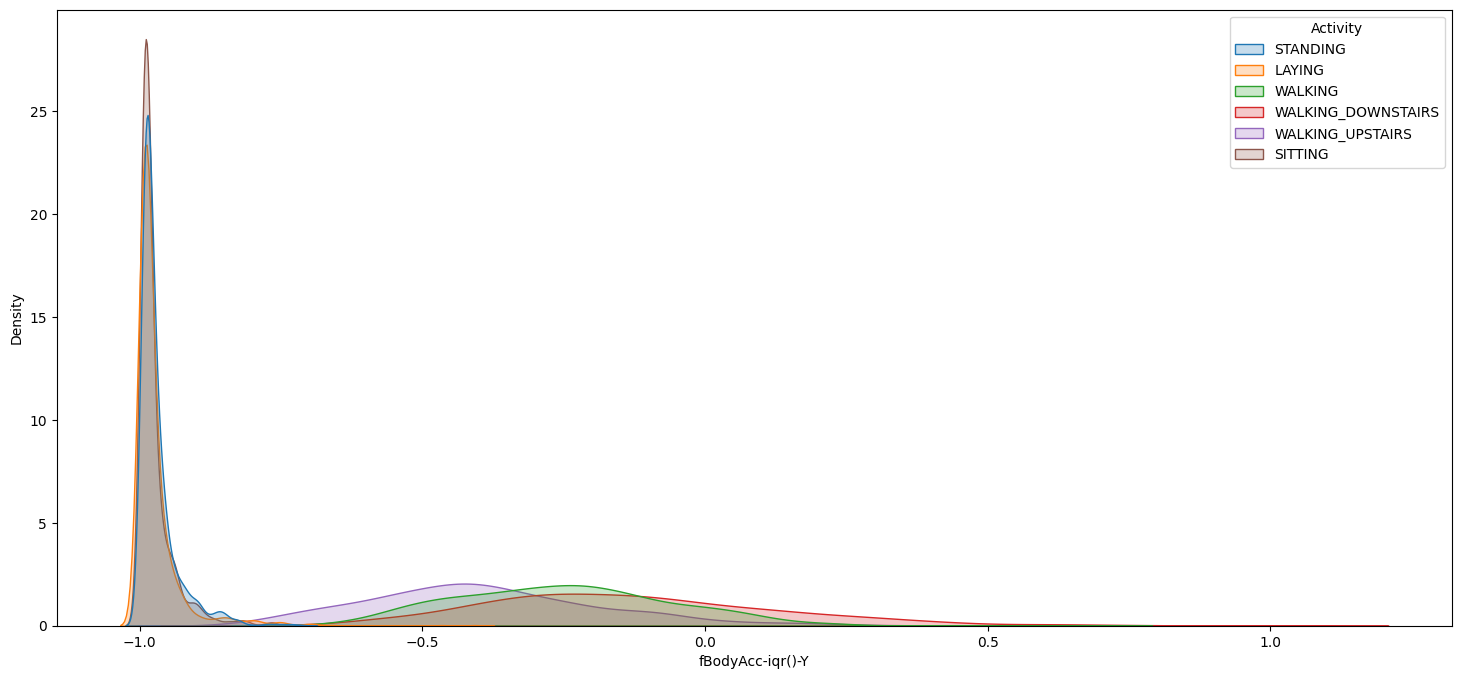

-----------------------------------------------
fBodyAcc-bandsEnergy()-57,64


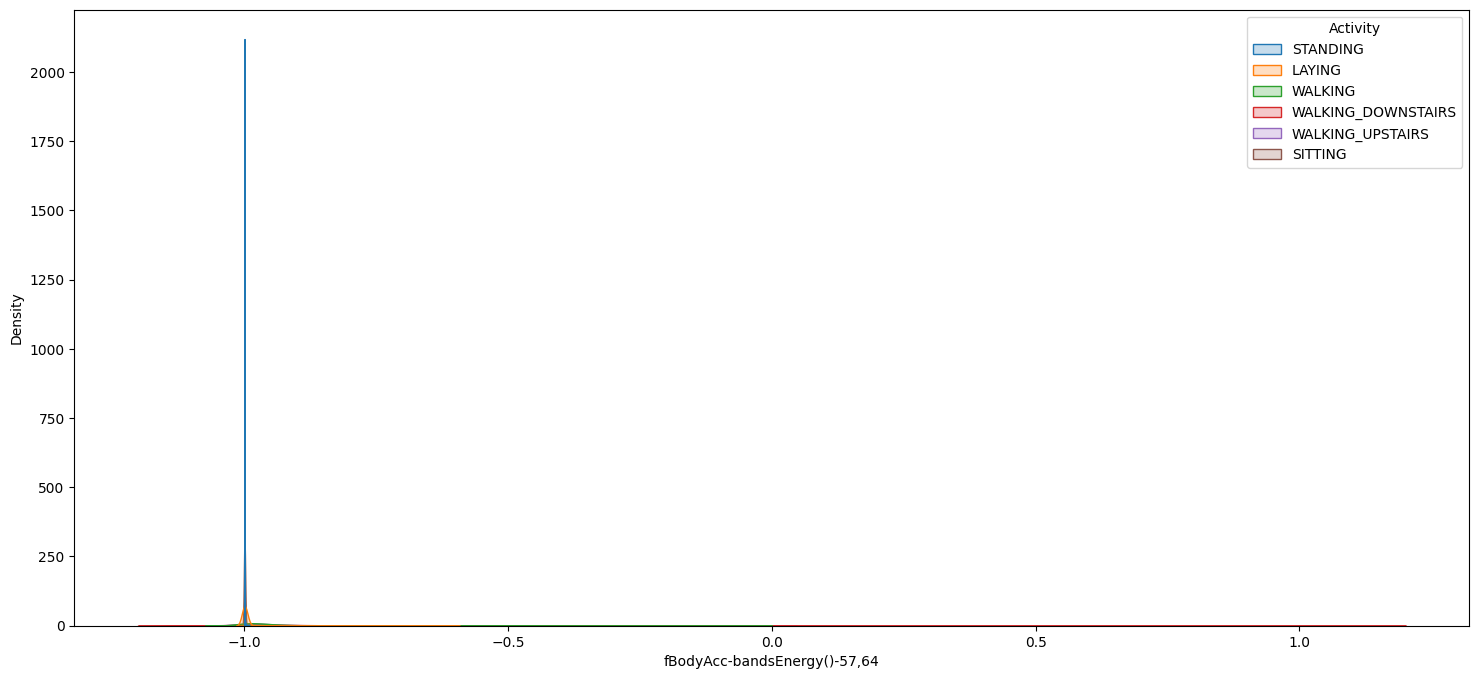

-----------------------------------------------
angle(tBodyAccJerkMean),gravityMean)


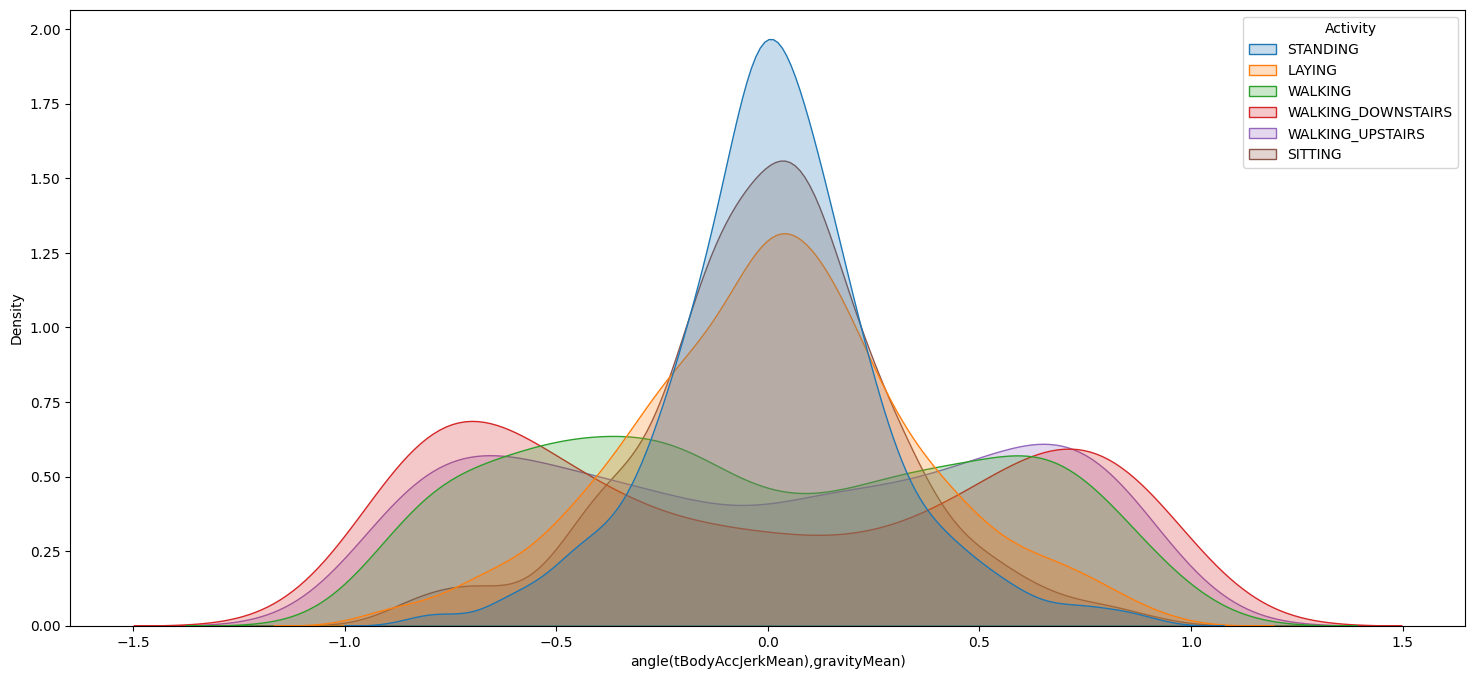

-----------------------------------------------
fBodyBodyAccJerkMag-min()


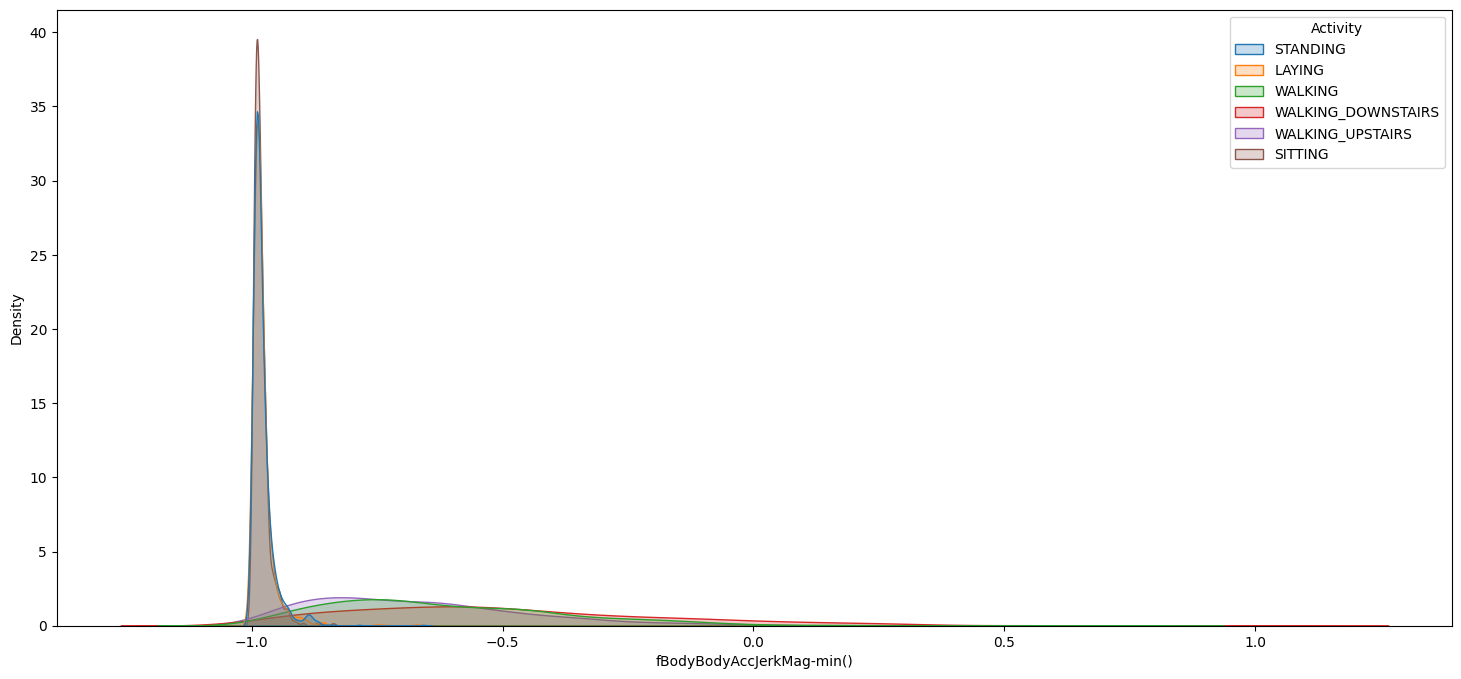

-----------------------------------------------
tBodyAcc-min()-Z


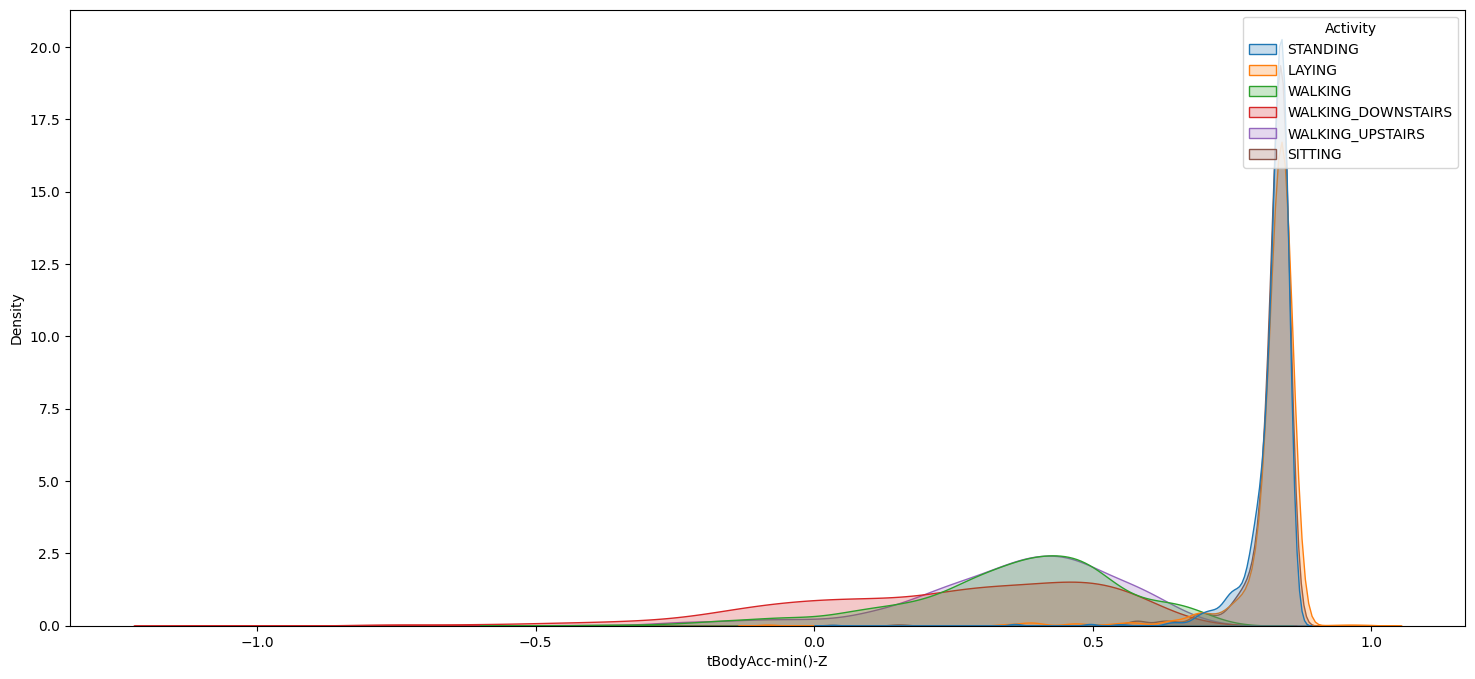

-----------------------------------------------
tBodyAccJerk-arCoeff()-Y,2


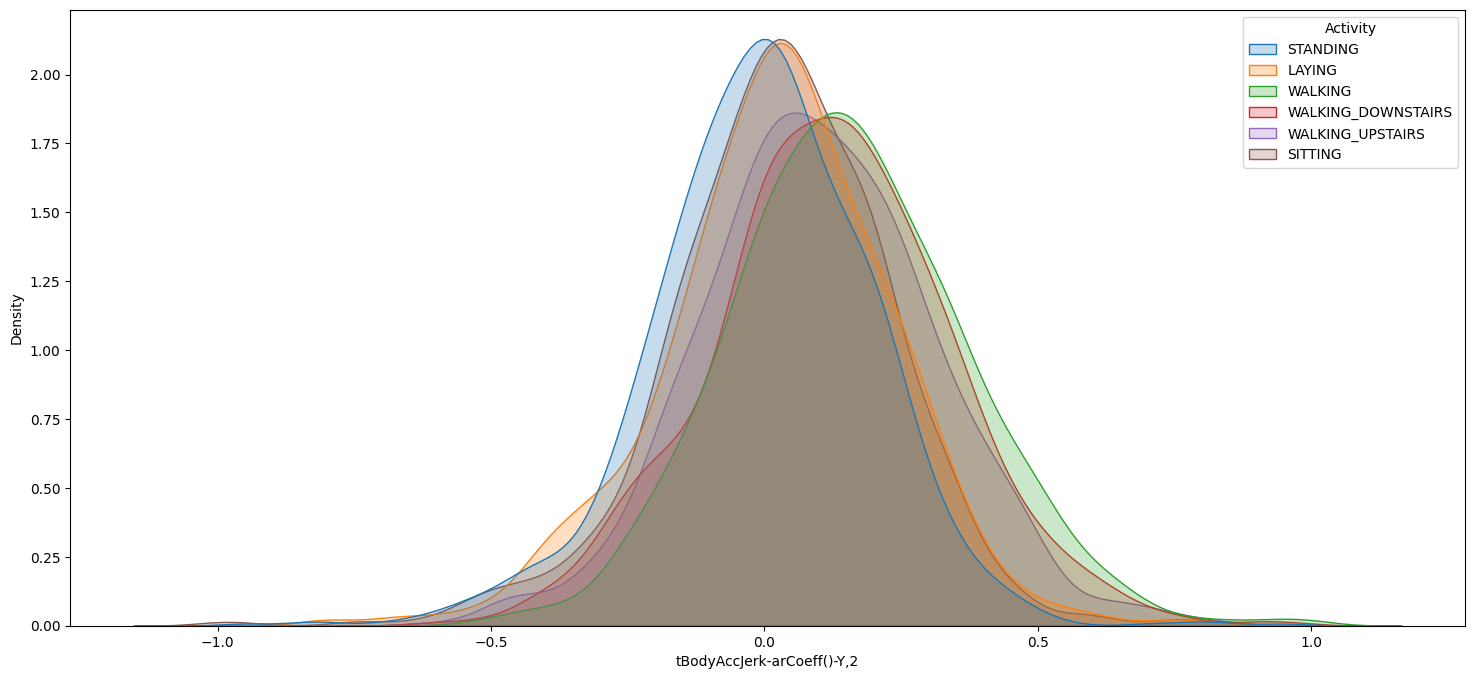

-----------------------------------------------
fBodyAcc-bandsEnergy()-49,56


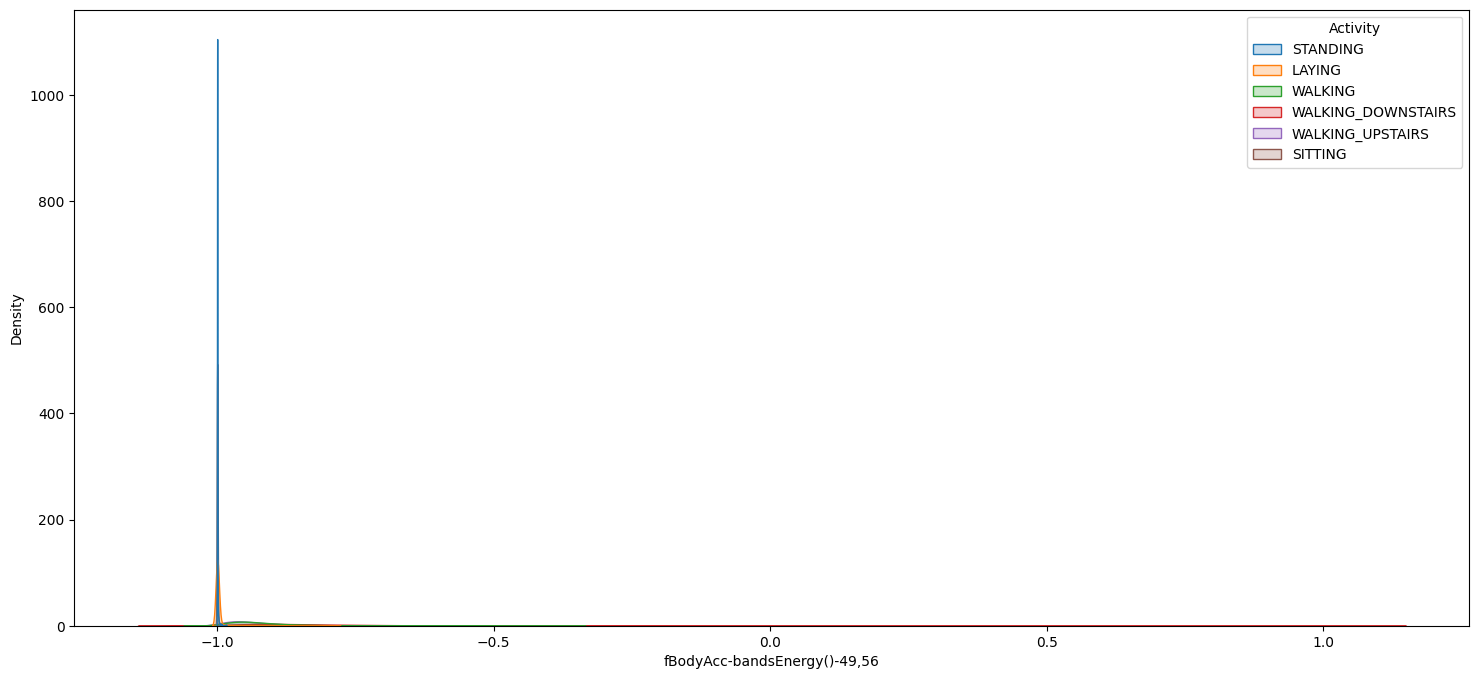

-----------------------------------------------
fBodyAcc-min()-Y


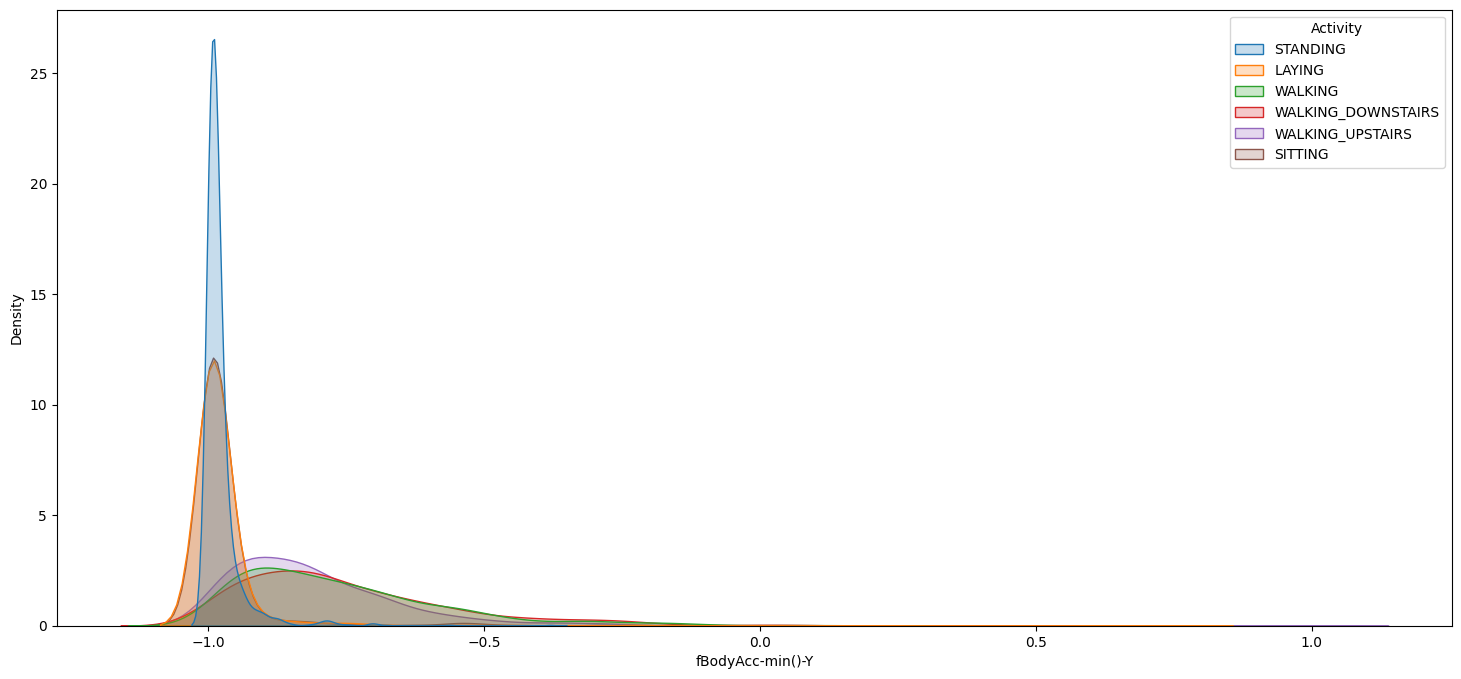

-----------------------------------------------
tBodyGyroJerk-arCoeff()-Z,1


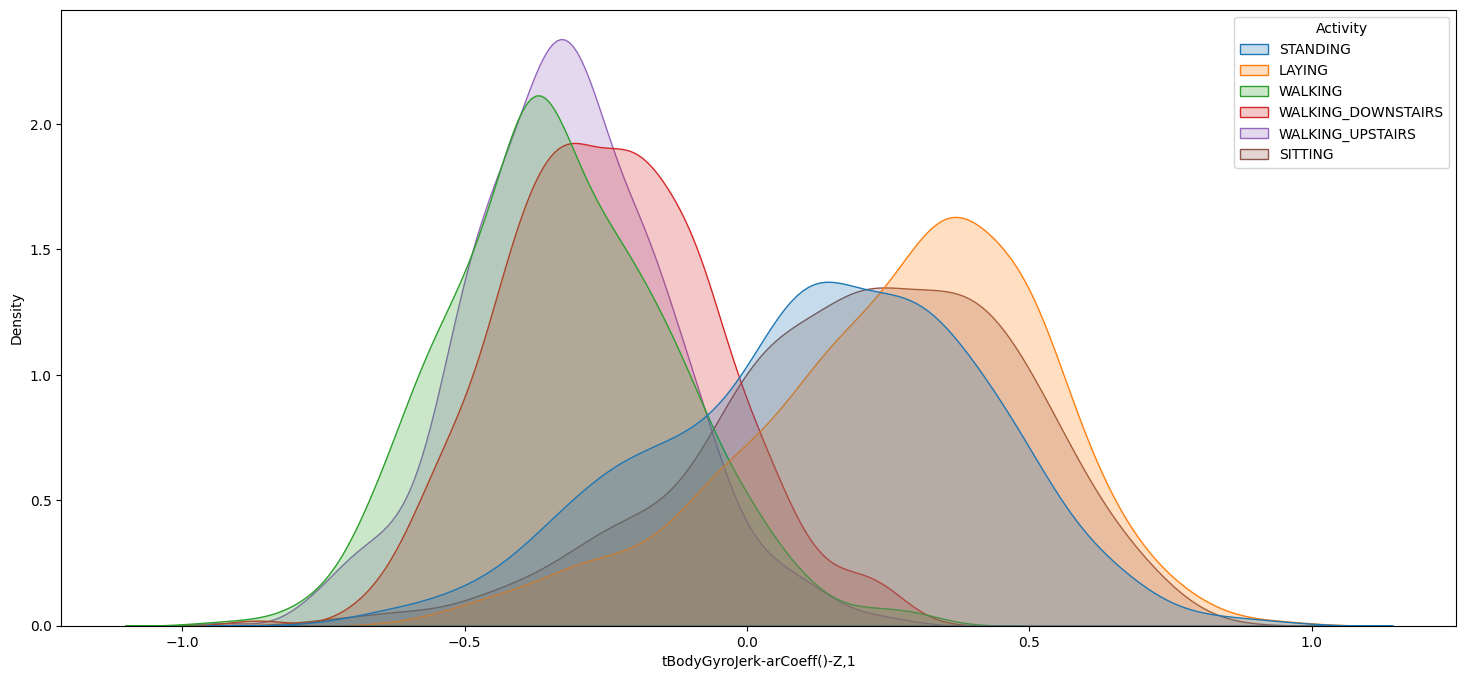

-----------------------------------------------
tBodyGyroMag-std()


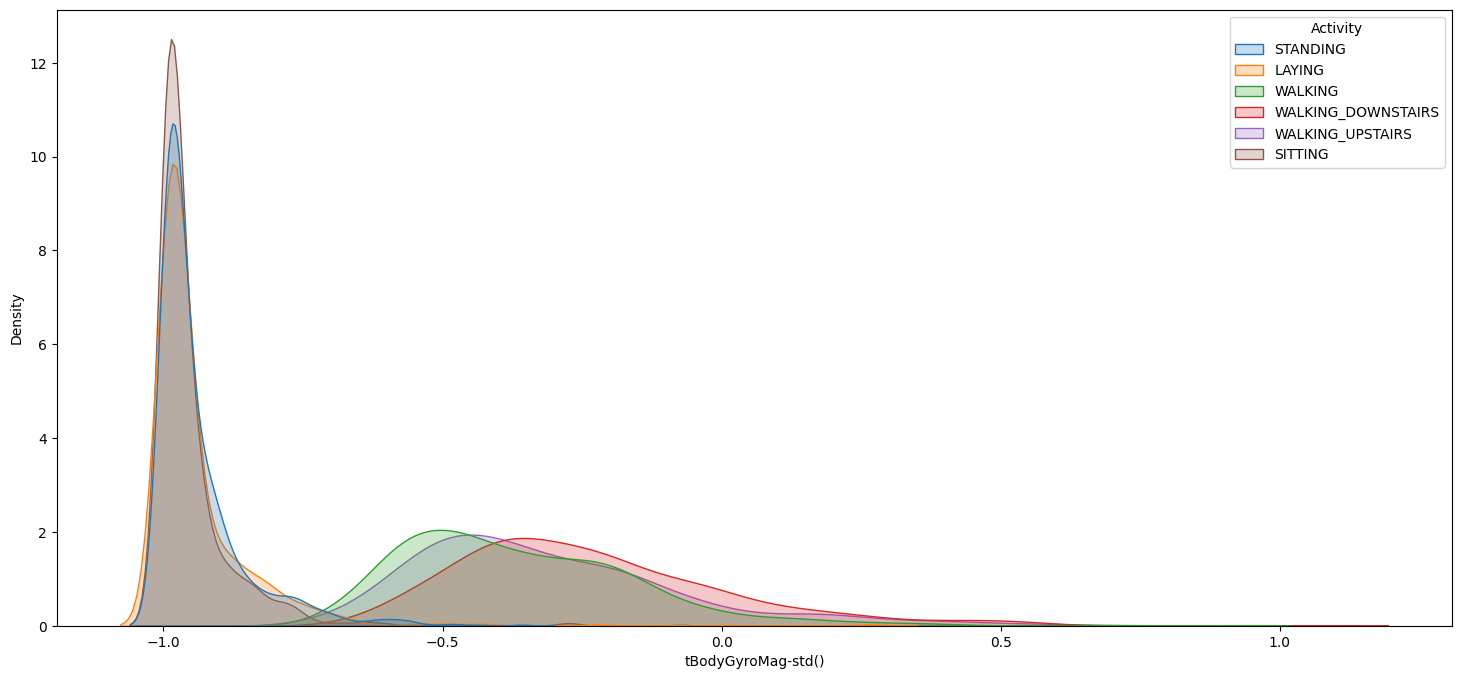

-----------------------------------------------
tBodyAcc-arCoeff()-Y,2


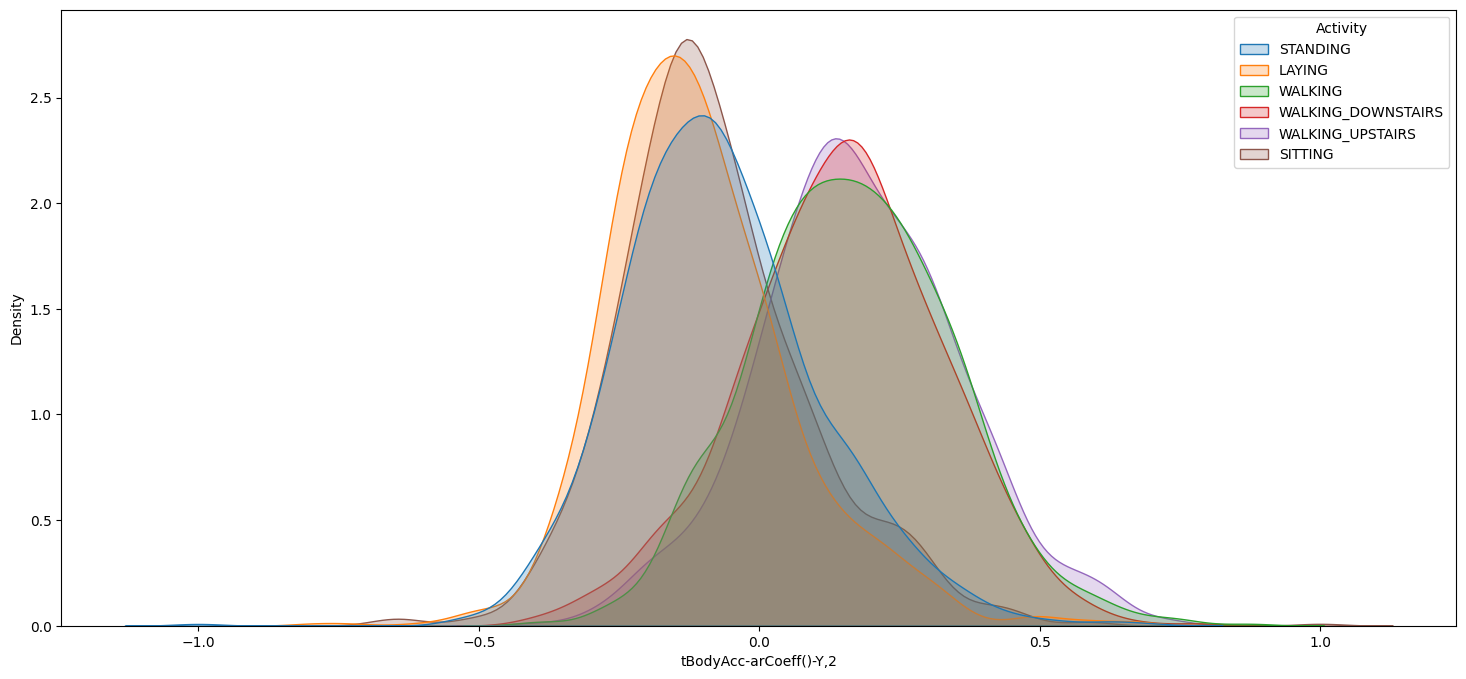

-----------------------------------------------
fBodyAccJerk-entropy()-Y


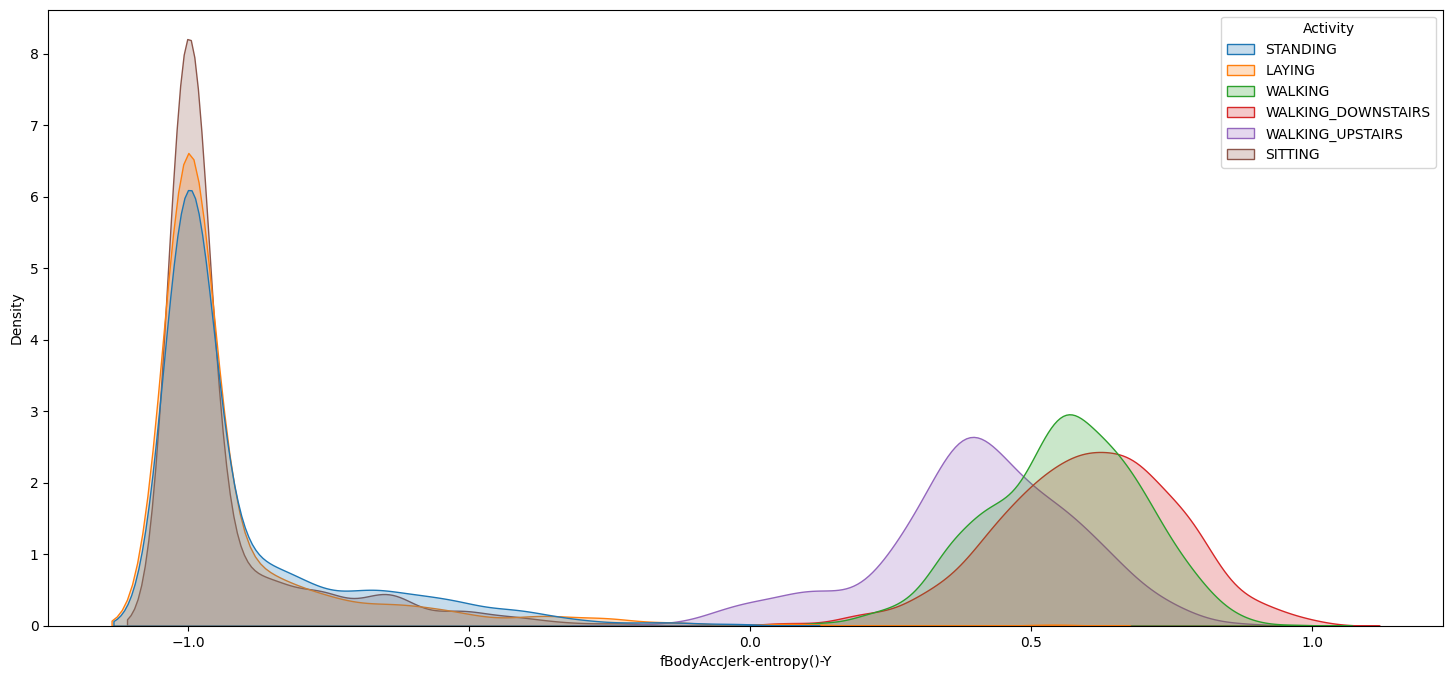

-----------------------------------------------


In [ ]:
for i in b:
    print(i)
    plt.figure(figsize=(18,8))
    sns.kdeplot(data=data,x=i,hue=target,common_norm=False,fill=True)
    plt.show()
    print("-----------------------------------------------")

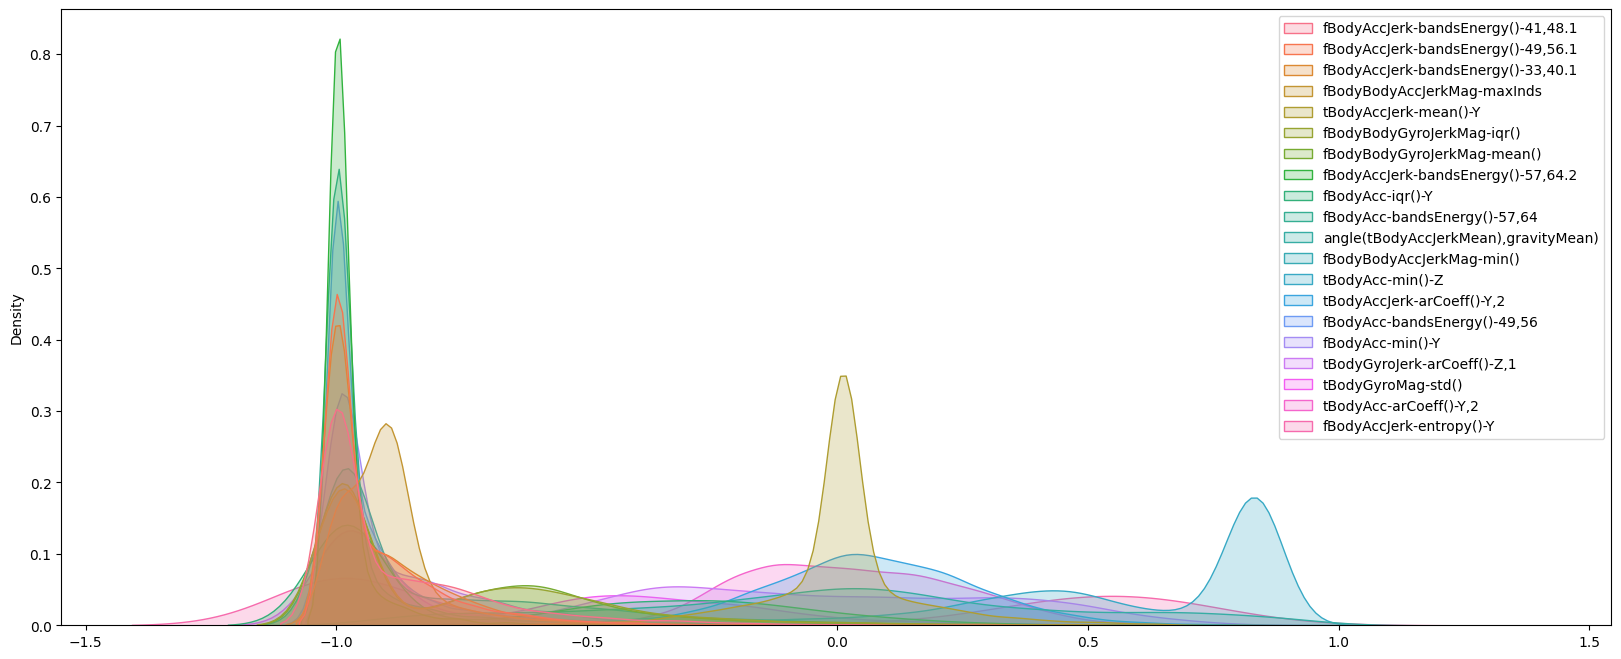

In [ ]:
plt.figure(figsize=(20,8))
sns.kdeplot(data=x_train[b],fill=True)
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [24]:
features=pd.merge(features,fi_temp,on="feature_name")

In [25]:
features.groupby("sensor").mean("feature_importance").sort_values("feature_importance",ascending=False)

,feature_importance
sensor,
angle,0.009554
tGravityAcc,0.008539
fBodyAccMag,0.003252
tBodyAccJerkMag,0.002831
tGravityAccMag,0.002238
tBodyAccMag,0.002117
tBodyAccJerk,0.001451
fBodyAccJerk,0.001363
fBodyBodyAccJerkMag,0.001355


In [26]:
fi_temp

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.036467
1,"angle(X,gravityMean)",0.029993
2,tGravityAcc-min()-X,0.026871
3,tGravityAcc-mean()-X,0.026578
4,tGravityAcc-max()-Y,0.025537
...,...,...
556,"fBodyAccJerk-bandsEnergy()-49,56",0.000083
557,"fBodyAccJerk-bandsEnergy()-49,56.1",0.000080
558,tBodyGyroJerk-entropy()-Y,0.000079
559,"fBodyGyro-bandsEnergy()-57,64.1",0.000059


In [27]:
features.groupby(["sensor","agg"]).mean("feature_importance").sort_values("feature_importance",ascending=False)

feature_importance
sensor               agg                           
angle                X                     0.029993
                     Y                     0.024766
tGravityAcc          mean()                0.020765
                     min()                 0.019483
                     energy()              0.019413
...                                             ...
fBodyBodyGyroJerkMag maxInds               0.000122
tBodyAccMag          arCoeff()4            0.000113
fBodyBodyAccJerkMag  min()                 0.000105
fBodyBodyGyroJerkMag iqr()                 0.000105
                     mean()                0.000091

[221 rows x 1 columns]

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [32]:
target="Activity"
data["is_dynamic"]=data[target].map({"STANDING":0,"SITTING":0,"LAYING":0,"WALKING":1,"WALKING_UPSTAIRS":1,"WALKING_DOWNSTAIRS":1})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1


#### 2) 기본모델 생성

In [33]:
x = data.drop([target,"is_dynamic"],axis=1)
y = data["is_dynamic"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()

In [34]:
model.fit(x_train,y_train)

RandomForestClassifier()

#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,16",0.060111
1,tBodyGyroJerk-sma(),0.059684
2,fBodyAccJerk-max()-X,0.049966
3,fBodyAccJerk-std()-X,0.049855
4,tBodyAccJerk-iqr()-X,0.040127
5,tBodyAccJerk-std()-X,0.040017
6,tBodyAccJerk-mad()-X,0.039947
7,"fBodyAccJerk-bandsEnergy()-1,8",0.039940
8,fBodyAccJerk-sma(),0.039736
9,fBodyAccJerk-entropy()-X,0.029949


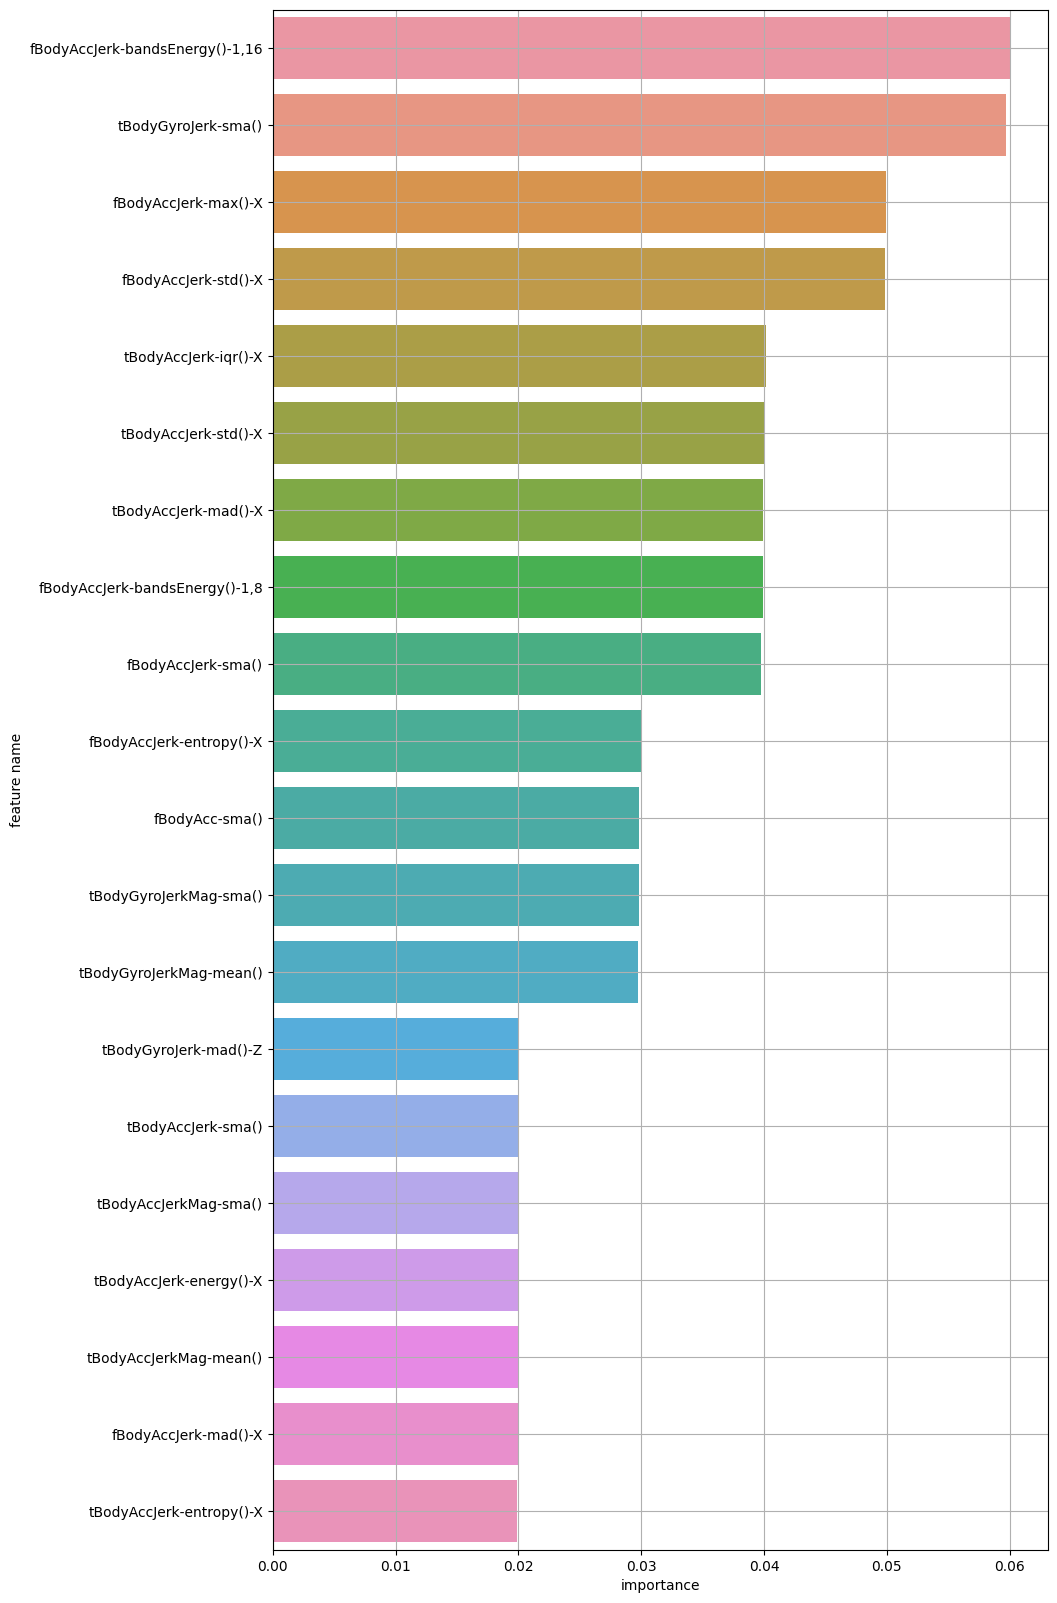

In [35]:
plot_feature_importance(model.feature_importances_,x_train.columns,result_only = False, topn =20)

In [36]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,16",0.060111
1,tBodyGyroJerk-sma(),0.059684
2,fBodyAccJerk-max()-X,0.049966
3,fBodyAccJerk-std()-X,0.049855
4,tBodyAccJerk-iqr()-X,0.040127
...,...,...
556,tBodyGyroJerkMag-mad(),0.000000
557,tBodyGyroJerkMag-std(),0.000000
558,tBodyGyroMag-arCoeff()4,0.000000
559,tBodyGyroMag-arCoeff()3,0.000000


#### 4) feature 그룹별 분석

In [37]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_x,feature_importance_y
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000
...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154


In [38]:
features.groupby("sensor").mean("feature_importance_y").sort_values("feature_importance_y",ascending=False)

,feature_importance_x,feature_importance_y
sensor,,
tBodyAccJerk,0.001451,5.741799e-03
fBodyAccJerk,0.001363,5.050752e-03
tBodyAccJerkMag,0.002831,4.606819e-03
tBodyGyroJerkMag,0.000734,4.577576e-03
tBodyGyroJerk,0.000779,2.741710e-03
fBodyBodyAccJerkMag,0.001355,1.527606e-03
fBodyAccMag,0.003252,7.738442e-04
fBodyAcc,0.000991,6.348868e-04
tBodyAcc,0.001187,5.052873e-04


In [49]:
features.groupby(["sensor","agg"]).mean("feature_importance_y").sort_values("feature_importance_y",ascending=False).head(20)

feature_importance_x  feature_importance_y  \
sensor           agg                                                     
tBodyGyroJerk    sma()                  0.000239              0.059684   
fBodyAccJerk     sma()                  0.002381              0.039736   
fBodyAcc         sma()                  0.000666              0.029828   
tBodyGyroJerkMag sma()                  0.002266              0.029795   
                 mean()                 0.004310              0.029714   
tBodyAccJerk     iqr()                  0.002214              0.019997   
                 sma()                  0.004508              0.019954   
tBodyAccJerkMag  sma()                  0.014350              0.019940   
                 mean()                 0.006365              0.019940   
fBodyGyro        sma()                  0.002363              0.019863   
fBodyAccJerk     max()                  0.004478              0.016661   
tBodyAccJerk     mad()                  0.004695              0.016626   
fBodyAccJerk     std()                  0.002566              0.016623   
tBodyAccJerk     std()                  0.001710              0.013356   
                 entropy()              0.002475              0.013242   
tBodyAccJerkMag  entropy()              0.004685              0.010009   
fBodyAccJerk     entropy()              0.002753              0.009983   
                 mean()                 0.002984              0.009937   
                 mad()                  0.002620              0.009926   
tBodyAccJerkMag  energy()               0.004175              0.009923   

                            feature_importance  
sensor           agg                            
tBodyGyroJerk    sma()                0.000456  
fBodyAccJerk     sma()                0.000202  
fBodyAcc         sma()                0.000233  
tBodyGyroJerkMag sma()                0.000252  
                 mean()               0.000203  
tBodyAccJerk     iqr()                0.000542  
                 sma()                0.000166  
tBodyAccJerkMag  sma()                0.000376  
                 mean()               0.000734  
fBodyGyro        sma()                0.000423  
fBodyAccJerk     max()                0.000806  
tBodyAccJerk     mad()                0.000407  
fBodyAccJerk     std()                0.001004  
tBodyAccJerk     std()                0.000979  
                 entropy()            0.001454  
tBodyAccJerkMag  entropy()            0.000394  
fBodyAccJerk     entropy()            0.000143  
                 mean()               0.000568  
                 mad()                0.000324  
tBodyAccJerkMag  energy()             0.000302

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [40]:
data["is_standing"]=data[target].map({"STANDING":1,"SITTING":0,"LAYING":0,"WALKING":0,"WALKING_UPSTAIRS":0,"WALKING_DOWNSTAIRS":0})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,0


In [41]:
x = data.drop([target,"is_dynamic","is_standing"],axis=1)
y = data["is_standing"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()

In [42]:
model.fit(x_train,y_train)

RandomForestClassifier()

,feature_name,feature_importance
0,tGravityAcc-mean()-Y,0.062912
1,tGravityAcc-max()-Y,0.056438
2,tGravityAcc-min()-Y,0.050356
3,"angle(Y,gravityMean)",0.031652
4,tGravityAcc-energy()-X,0.024901
5,"angle(Z,gravityMean)",0.023370
6,tGravityAcc-mean()-Z,0.022459
7,tGravityAcc-mean()-X,0.021473
8,tGravityAcc-min()-Z,0.020708
9,tGravityAcc-entropy()-Y,0.018915


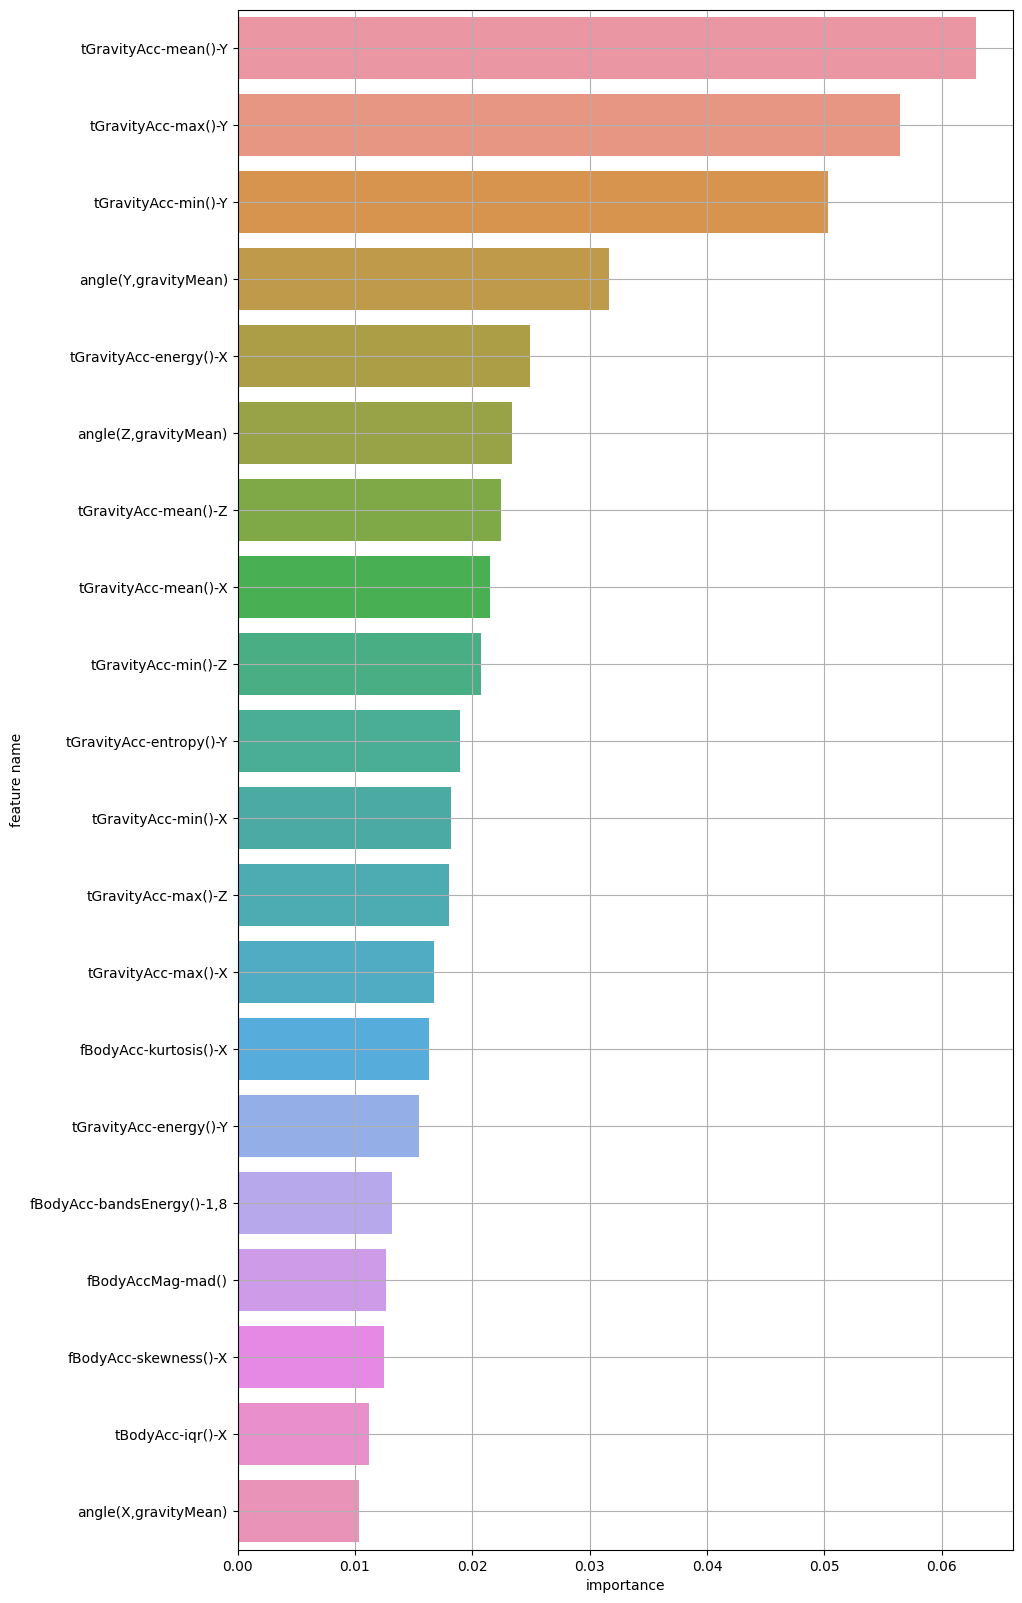

In [43]:
plot_feature_importance(model.feature_importances_,x_train.columns,result_only = False, topn =20)

In [44]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,tGravityAcc-mean()-Y,0.062912
1,tGravityAcc-max()-Y,0.056438
2,tGravityAcc-min()-Y,0.050356
3,"angle(Y,gravityMean)",0.031652
4,tGravityAcc-energy()-X,0.024901
...,...,...
556,fBodyAccMag-max(),0.000055
557,tBodyAccMag-energy(),0.000047
558,fBodyAccJerk-entropy()-Y,0.000045
559,fBodyGyro-maxInds-Z,0.000038


In [45]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_x,feature_importance_y,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033
...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652


In [46]:
features.groupby("sensor").mean("feature_importance").sort_values("feature_importance",ascending=False)

,feature_importance_x,feature_importance_y,feature_importance
sensor,,,
angle,0.009554,2.683695e-05,0.010001
tGravityAcc,0.008539,3.413619e-05,0.009755
fBodyAccMag,0.003252,7.738442e-04,0.002099
tBodyGyro,0.000791,1.311794e-05,0.001645
tGravityAccMag,0.002238,1.003457e-05,0.001612
fBodyAcc,0.000991,6.348868e-04,0.001574
tBodyAcc,0.001187,5.052873e-04,0.001530
tBodyAccMag,0.002117,1.176460e-07,0.001437
tBodyGyroMag,0.000257,0.000000e+00,0.001258


In [48]:
features.groupby(["sensor","agg"]).mean("feature_importance").sort_values("feature_importance",ascending=False).head(20)

feature_importance_x  feature_importance_y  \
sensor       agg                                                      
tGravityAcc  mean()                  0.020765          9.690332e-05   
angle        Y                       0.024766          1.536509e-04   
tGravityAcc  max()                   0.018131          7.419520e-05   
             min()                   0.019483          6.255157e-05   
angle        Z                       0.010591          0.000000e+00   
tGravityAcc  energy()                0.019413          9.890771e-05   
fBodyAccMag  mad()                   0.007152          0.000000e+00   
angle        X                       0.029993          3.420772e-05   
fBodyAccMag  sma()                   0.006058          0.000000e+00   
tGravityAcc  sma()                   0.004450          7.829002e-06   
tBodyGyroMag sma()                   0.000233          0.000000e+00   
tGravityAcc  entropy()               0.003691          5.697203e-06   
tBodyAccMag  std()                   0.005888          0.000000e+00   
fBodyAcc     kurtosis()              0.000697          0.000000e+00   
tBodyAccMag  mad()                   0.011124          0.000000e+00   
tBodyAcc     iqr()                   0.000644          7.928768e-07   
tBodyAccMag  sma()                   0.001063          0.000000e+00   
fBodyAcc     skewness()              0.001289          0.000000e+00   
tBodyGyro    sma()                   0.000362          2.050787e-05   
             energy()                0.000956          0.000000e+00   

                         feature_importance  
sensor       agg                             
tGravityAcc  mean()                0.035615  
angle        Y                     0.031652  
tGravityAcc  max()                 0.030387  
             min()                 0.029741  
angle        Z                     0.023370  
tGravityAcc  energy()              0.015495  
fBodyAccMag  mad()                 0.012674  
angle        X                     0.010309  
fBodyAccMag  sma()                 0.008446  
tGravityAcc  sma()                 0.008146  
tBodyGyroMag sma()                 0.007304  
tGravityAcc  entropy()             0.006704  
tBodyAccMag  std()                 0.006442  
fBodyAcc     kurtosis()            0.005734  
tBodyAccMag  mad()                 0.004887  
tBodyAcc     iqr()                 0.004591  
tBodyAccMag  sma()                 0.004555  
fBodyAcc     skewness()            0.004507  
tBodyGyro    sma()                 0.004428  
             energy()              0.004244

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [50]:
data["is_sitting"]=data[target].map({"STANDING":0,"SITTING":1,"LAYING":0,"WALKING":0,"WALKING_UPSTAIRS":0,"WALKING_DOWNSTAIRS":0})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0,0,1
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,0,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0,0,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,0,0


In [51]:
x = data.drop([target,"is_dynamic","is_standing","is_sitting"],axis=1)
y = data["is_sitting"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()

In [52]:
model.fit(x_train,y_train)

RandomForestClassifier()

In [53]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,"angle(Y,gravityMean)",0.064100
1,tGravityAcc-mean()-Y,0.044438
2,tGravityAcc-min()-Y,0.040626
3,tGravityAcc-max()-Y,0.035480
4,tGravityAcc-mean()-X,0.033677
...,...,...
556,fBodyBodyAccJerkMag-entropy(),0.000064
557,fBodyAccJerk-entropy()-Y,0.000050
558,fBodyAcc-maxInds-Z,0.000048
559,fBodyAccMag-maxInds,0.000038


In [54]:
features=features.rename(columns={"feature_importance_x": "feature_importance_1","feature_importance_y":"feature_importance_2","feature_importance":"feature_importance_3"})

In [55]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368
...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100


In [56]:
features=features.rename(columns={"feature_importance": "feature_importance_4"})
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368
...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100


In [57]:
features.groupby("sensor").mean("feature_importance_4").sort_values("feature_importance_4",ascending=False)

,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4
sensor,,,,
angle,0.009554,2.683695e-05,0.010001,0.013362
tGravityAcc,0.008539,3.413619e-05,0.009755,0.008624
fBodyGyro,0.000808,5.023856e-04,0.001198,0.002539
tBodyGyro,0.000791,1.311794e-05,0.001645,0.002162
tBodyGyroJerk,0.000779,2.741710e-03,0.000918,0.001550
tBodyAcc,0.001187,5.052873e-04,0.001530,0.000948
tBodyAccJerkMag,0.002831,4.606819e-03,0.000316,0.000782
fBodyAcc,0.000991,6.348868e-04,0.001574,0.000651
fBodyAccJerk,0.001363,5.050752e-03,0.000428,0.000644


In [58]:
features.groupby(["sensor","agg"]).mean("feature_importance_4").sort_values("feature_importance_4",ascending=False).head(20)

feature_importance_1  feature_importance_2  \
sensor        agg                                                         
angle         Y                          0.024766          1.536509e-04   
tGravityAcc   mean()                     0.020765          9.690332e-05   
              min()                      0.019483          6.255157e-05   
              max()                      0.018131          7.419520e-05   
              energy()                   0.019413          9.890771e-05   
angle         X                          0.029993          3.420772e-05   
              Z                          0.010591          0.000000e+00   
fBodyGyro     max()                      0.001338          4.688263e-06   
tBodyGyro     mad()                      0.000991          5.755103e-05   
fBodyGyro     energy()                   0.000965          8.640667e-06   
              mean()                     0.000663          3.290619e-03   
tBodyGyro     max()                      0.000887          0.000000e+00   
fBodyGyro     mad()                      0.001311          0.000000e+00   
              std()                      0.001342          0.000000e+00   
tBodyGyro     iqr()                      0.001602          1.046667e-04   
tGravityAcc   correlation()              0.002847          8.579940e-06   
tBodyAcc      correlation()              0.003436          0.000000e+00   
tBodyGyroJerk std()                      0.000844          2.852562e-06   
tGravityAcc   sma()                      0.004450          7.829002e-06   
tBodyGyro     std()                      0.000695          8.095236e-07   

                             feature_importance_3  feature_importance_4  
sensor        agg                                                        
angle         Y                          0.031652              0.064100  
tGravityAcc   mean()                     0.035615              0.029245  
              min()                      0.029741              0.026885  
              max()                      0.030387              0.025550  
              energy()                   0.015495              0.022435  
angle         X                          0.010309              0.018144  
              Z                          0.023370              0.009264  
fBodyGyro     max()                      0.001428              0.008779  
tBodyGyro     mad()                      0.003356              0.007036  
fBodyGyro     energy()                   0.002252              0.005587  
              mean()                     0.002823              0.005413  
tBodyGyro     max()                      0.002242              0.005176  
fBodyGyro     mad()                      0.001841              0.005034  
              std()                      0.002715              0.004938  
tBodyGyro     iqr()                      0.001692              0.004317  
tGravityAcc   correlation()              0.001827              0.003419  
tBodyAcc      correlation()              0.003210              0.003310  
tBodyGyroJerk std()                      0.001297              0.003164  
tGravityAcc   sma()                      0.008146              0.003077  
tBodyGyro     std()                      0.001326              0.002861

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [59]:
data["is_laying"]=data[target].map({"STANDING":0,"SITTING":0,"LAYING":1,"WALKING":0,"WALKING_UPSTAIRS":0,"WALKING_DOWNSTAIRS":0})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0,0,1,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,0,0,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0,0,0,1
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,0,0,0


In [60]:
x = data.drop([target,"is_dynamic","is_standing","is_sitting","is_laying"],axis=1)
y = data["is_laying"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [61]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.121378
1,tGravityAcc-max()-X,0.100489
2,tGravityAcc-mean()-X,0.097076
3,"angle(X,gravityMean)",0.062332
4,tGravityAcc-min()-X,0.056558
...,...,...
556,"fBodyGyro-bandsEnergy()-49,56.2",0.000000
557,tBodyGyroJerk-min()-Y,0.000000
558,fBodyAcc-meanFreq()-Y,0.000000
559,"tBodyAcc-arCoeff()-X,2",0.000000


In [62]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000
...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778


In [63]:
features=features.rename(columns={"feature_importance": "feature_importance_5"})
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000
...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778


In [64]:
features.groupby("sensor").mean("feature_importance_5").sort_values("feature_importance_5",ascending=False)

,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5
sensor,,,,,
angle,0.009554,2.683695e-05,0.010001,0.013362,0.018445
tGravityAcc,0.008539,3.413619e-05,0.009755,0.008624,0.016961
tBodyAcc,0.001187,5.052873e-04,0.001530,0.000948,0.000641
tBodyGyro,0.000791,1.311794e-05,0.001645,0.002162,0.000513
fBodyAccJerk,0.001363,5.050752e-03,0.000428,0.000644,0.000482
tBodyAccJerkMag,0.002831,4.606819e-03,0.000316,0.000782,0.000477
tBodyAccJerk,0.001451,5.741799e-03,0.000504,0.000518,0.000472
fBodyAcc,0.000991,6.348868e-04,0.001574,0.000651,0.000447
fBodyGyro,0.000808,5.023856e-04,0.001198,0.002539,0.000428


In [65]:
features.groupby(["sensor","agg"]).mean("feature_importance_5").sort_values("feature_importance_5",ascending=False).head(20)

feature_importance_1  feature_importance_2  \
sensor          agg                                                         
angle           X                          0.029993              0.000034   
tGravityAcc     energy()                   0.019413              0.000099   
                mean()                     0.020765              0.000097   
                max()                      0.018131              0.000074   
angle           Y                          0.024766              0.000154   
tGravityAcc     min()                      0.019483              0.000063   
angle           Z                          0.010591              0.000000   
tBodyAcc        correlation()              0.003436              0.000000   
tGravityAcc     sma()                      0.004450              0.000008   
                correlation()              0.002847              0.000009   
tBodyAccJerk    iqr()                      0.002214              0.019997   
tBodyGyro       iqr()                      0.001602              0.000105   
fBodyGyro       std()                      0.001342              0.000000   
fBodyAccJerk    entropy()                  0.002753              0.009983   
tGravityAcc     entropy()                  0.003691              0.000006   
tBodyAccJerkMag mean()                     0.006365              0.019940   
tBodyGyroJerk   sma()                      0.000239              0.059684   
fBodyAccJerk    std()                      0.002566              0.016623   
tBodyAccJerkMag entropy()                  0.004685              0.010009   
fBodyAccJerk    sma()                      0.002381              0.039736   

                               feature_importance_3  feature_importance_4  \
sensor          agg                                                         
angle           X                          0.010309              0.018144   
tGravityAcc     energy()                   0.015495              0.022435   
                mean()                     0.035615              0.029245   
                max()                      0.030387              0.025550   
angle           Y                          0.031652              0.064100   
tGravityAcc     min()                      0.029741              0.026885   
angle           Z                          0.023370              0.009264   
tBodyAcc        correlation()              0.003210              0.003310   
tGravityAcc     sma()                      0.008146              0.003077   
                correlation()              0.001827              0.003419   
tBodyAccJerk    iqr()                      0.000542              0.000517   
tBodyGyro       iqr()                      0.001692              0.004317   
fBodyGyro       std()                      0.002715              0.004938   
fBodyAccJerk    entropy()                  0.000143              0.000069   
tGravityAcc     entropy()                  0.006704              0.002625   
tBodyAccJerkMag mean()                     0.000734              0.000902   
tBodyGyroJerk   sma()                      0.000456              0.000330   
fBodyAccJerk    std()                      0.001004              0.000516   
tBodyAccJerkMag entropy()                  0.000394              0.002325   
fBodyAccJerk    sma()                      0.000202              0.000266   

                               feature_importance_5  
sensor          agg                                  
angle           X                          0.062332  
tGravityAcc     energy()                   0.061451  
                mean()                     0.056381  
                max()                      0.052995  
angle           Y                          0.050778  
tGravityAcc     min()                      0.044325  
angle           Z                          0.015843  
tBodyAcc        correlation()              0.004847  
tGravityAcc     sma()                      0.003944  
                correlation()              0.00

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [66]:
data["is_walking"]=data[target].map({"STANDING":0,"SITTING":0,"LAYING":0,"WALKING":1,"WALKING_UPSTAIRS":0,"WALKING_DOWNSTAIRS":0})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.072790,-0.601120,0.331298,0.165163,STANDING,0,1,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.771524,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.021528,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.072944,-0.695819,0.287154,0.111388,WALKING,1,0,0,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.877612,-0.912365,0.114009,0.080146,SITTING,0,0,1,0,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,0,0,0,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0,0,0,1,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,0,0,0,0


In [67]:
x = data.drop([target,"is_dynamic","is_standing","is_sitting","is_laying","is_walking"],axis=1)
y = data["is_walking"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [68]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,"tBodyAcc-correlation()-X,Y",0.025384
1,"tGravityAcc-arCoeff()-X,3",0.023451
2,fBodyAccMag-std(),0.021317
3,tBodyGyroJerk-mad()-X,0.019724
4,fBodyAccMag-max(),0.019003
...,...,...
556,"fBodyAcc-bandsEnergy()-57,64.2",0.000014
557,fBodyBodyAccJerkMag-energy(),0.000014
558,"fBodyAcc-bandsEnergy()-49,56.2",0.000010
559,"fBodyAcc-bandsEnergy()-1,24.2",0.000000


In [69]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217
...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233


In [70]:
features=features.rename(columns={"feature_importance": "feature_importance_6"})
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217
...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233


In [71]:
features.groupby("sensor").mean("feature_importance_6").sort_values("feature_importance_6",ascending=False)

,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6
sensor,,,,,,
tBodyAccMag,0.002117,1.176460e-07,0.001437,0.000260,0.000084,0.006094
fBodyAccMag,0.003252,7.738442e-04,0.002099,0.000367,0.000034,0.006035
tGravityAccMag,0.002238,1.003457e-05,0.001612,0.000258,0.000056,0.005028
tGravityAcc,0.008539,3.413619e-05,0.009755,0.008624,0.016961,0.003940
tBodyGyroJerk,0.000779,2.741710e-03,0.000918,0.001550,0.000225,0.002769
fBodyAcc,0.000991,6.348868e-04,0.001574,0.000651,0.000447,0.001634
fBodyBodyGyroJerkMag,0.000262,2.366375e-06,0.000279,0.000443,0.000032,0.001540
fBodyAccJerk,0.001363,5.050752e-03,0.000428,0.000644,0.000482,0.001535
tBodyAcc,0.001187,5.052873e-04,0.001530,0.000948,0.000641,0.001479


In [72]:
features.groupby(["sensor","agg"]).mean("feature_importance_6").sort_values("feature_importance_6",ascending=False).head(20)

feature_importance_1  \
sensor               agg                                   
fBodyAccMag          std()                      0.009322   
                     max()                      0.001089   
tGravityAccMag       mad()                      0.004425   
tBodyAccMag          arCoeff()1                 0.005300   
                     std()                      0.005888   
fBodyBodyGyroJerkMag max()                      0.000362   
fBodyAccMag          mad()                      0.007152   
tBodyAccMag          mad()                      0.011124   
tBodyGyroJerk        mad()                      0.001311   
fBodyBodyAccJerkMag  max()                      0.000501   
tGravityAccMag       std()                      0.009297   
tBodyAccMag          sma()                      0.001063   
fBodyAccMag          energy()                   0.007725   
tGravityAccMag       arCoeff()1                 0.005081   
tGravityAcc          arCoeff()                  0.006180   
tBodyAcc             correlation()              0.003436   
tGravityAccMag       energy()                   0.002936   
tBodyGyroJerk        energy()                   0.002128   
                     std()                      0.000844   
tBodyAccMag          mean()                     0.000404   

                                    feature_importance_2  \
sensor               agg                                   
fBodyAccMag          std()                      0.000000   
                     max()                      0.000000   
tGravityAccMag       mad()                      0.000017   
tBodyAccMag          arCoeff()1                 0.000000   
                     std()                      0.000000   
fBodyBodyGyroJerkMag max()                      0.000000   
fBodyAccMag          mad()                      0.000000   
tBodyAccMag          mad()                      0.000000   
tBodyGyroJerk        mad()                      0.006664   
fBodyBodyAccJerkMag  max()                      0.000026   
tGravityAccMag       std()                      0.000000   
tBodyAccMag          sma()                      0.000000   
fBodyAccMag          energy()                   0.000000   
tGravityAccMag       arCoeff()1                 0.000000   
tGravityAcc          arCoeff()                  0.000004   
tBodyAcc             correlation()              0.000000   
tGravityAccMag       energy()                   0.000000   
tBodyGyroJerk        energy()                   0.000000   
                     std()                      0.000003   
tBodyAccMag          mean()                     0.000000   

                                    feature_importance_3  \
sensor               agg                                   
fBodyAccMag          std()                      0.002083   
                     max()                      0.000055   
tGravityAccMag       mad()                      0.004210   
tBodyAccMag          arCoeff()1                 0.000327   
                     std()                      0.006442   
fBodyBodyGyroJerkMag max()                      0.000721   
fBodyAccMag          mad()                      0.012674   
tBodyAccMag          mad()                      0.004887   
tBodyGyroJerk        mad()                      0.001825   
fBodyBodyAccJerkMag  max()                      0.000218   
tGravityAccMag       std()                      0.000507   
tBodyAccMag          sma()                      0.004555   
fBodyAccMag          energy()                   0.000174   
tGravityAccMag       arCoeff()1                 0.000345   
tGravityAcc          arCoeff()                  0.000830   
tBodyAcc             correlation()              0.003210   
tGravityAccMag       energy()                   0.003060   
tBodyGyroJerk        energy()                   0.000908   
                     std()                      0.001297   
tBodyAccMag          mean()                     0.000199   

                                    feature_importance_4  \
sensor       

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [73]:
data["is_walking_up"]=data[target].map({"STANDING":0,"SITTING":0,"LAYING":0,"WALKING":0,"WALKING_UPSTAIRS":1,"WALKING_DOWNSTAIRS":0})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.601120,0.331298,0.165163,STANDING,0,1,0,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.345205,-0.769186,-0.147944,LAYING,0,0,0,1,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.833564,0.202434,-0.032755,STANDING,0,1,0,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.695819,0.287154,0.111388,WALKING,1,0,0,0,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.912365,0.114009,0.080146,SITTING,0,0,1,0,0,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1,0,0,0,0,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,0.620363,-0.437247,-0.571840,LAYING,0,0,0,1,0,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1,0,0,0,0,1


In [74]:
x = data.drop([target,"is_dynamic","is_standing","is_sitting","is_laying","is_walking","is_walking_up"],axis=1)
y = data["is_walking_up"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [75]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.035383
1,"tGravityAcc-arCoeff()-Z,2",0.029551
2,"tGravityAcc-arCoeff()-Z,1",0.028263
3,tGravityAcc-mean()-Y,0.026436
4,"tGravityAcc-arCoeff()-Z,4",0.021387
...,...,...
556,tBodyGyroMag-max(),0.000025
557,fBodyBodyGyroMag-maxInds,0.000025
558,"tBodyAcc-arCoeff()-Y,2",0.000017
559,"fBodyGyro-bandsEnergy()-49,56.2",0.000016


In [76]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189,0.000252
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115,0.000469
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164,0.000240
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646,0.005475
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217,0.000172
...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266,0.000189
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084,0.000188
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979,0.005001
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233,0.017004


In [77]:
features=features.rename(columns={"feature_importance": "feature_importance_7"})
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189,0.000252
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115,0.000469
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164,0.000240
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646,0.005475
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217,0.000172
...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266,0.000189
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084,0.000188
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979,0.005001
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233,0.017004


In [78]:
features.groupby("sensor").mean("feature_importance_7").sort_values("feature_importance_7",ascending=False)

,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7
sensor,,,,,,,
tGravityAcc,0.008539,3.413619e-05,0.009755,0.008624,0.016961,0.003940,0.007050
angle,0.009554,2.683695e-05,0.010001,0.013362,0.018445,0.000704,0.003396
fBodyAcc,0.000991,6.348868e-04,0.001574,0.000651,0.000447,0.001634,0.002662
tBodyAccJerkMag,0.002831,4.606819e-03,0.000316,0.000782,0.000477,0.001112,0.002584
fBodyBodyAccJerkMag,0.001355,1.527606e-03,0.000250,0.000320,0.000046,0.001373,0.002301
fBodyAccMag,0.003252,7.738442e-04,0.002099,0.000367,0.000034,0.006035,0.001880
tBodyAccMag,0.002117,1.176460e-07,0.001437,0.000260,0.000084,0.006094,0.001445
tGravityAccMag,0.002238,1.003457e-05,0.001612,0.000258,0.000056,0.005028,0.001422
tBodyGyroMag,0.000257,0.000000e+00,0.001258,0.000532,0.000036,0.000349,0.001291


In [80]:
features.groupby(["sensor","agg"]).mean("feature_importance_7").sort_values("feature_importance_7",ascending=False).head(20)

feature_importance_1  feature_importance_2  \
sensor              agg                                                     
angle               Y                      0.024766              0.000154   
tGravityAcc         min()                  0.019483              0.000063   
                    arCoeff()              0.006180              0.000004   
fBodyBodyAccJerkMag max()                  0.000501              0.000026   
fBodyAcc            max()                  0.001589              0.000006   
tGravityAcc         mean()                 0.020765              0.000097   
tBodyAccJerkMag     mad()                  0.000897              0.000000   
fBodyGyro           maxInds                0.002497              0.000000   
tBodyAccJerkMag     entropy()              0.004685              0.010009   
tGravityAcc         energy()               0.019413              0.000099   
fBodyAccMag         mad()                  0.007152              0.000000   
fBodyBodyAccJerkMag std()                  0.001103              0.000000   
tBodyGyroMag        sma()                  0.000233              0.000000   
tGravityAcc         sma()                  0.004450              0.000008   
tBodyAccJerkMag     iqr()                  0.004902              0.000000   
fBodyAccJerk        std()                  0.002566              0.016623   
fBodyBodyAccJerkMag mad()                  0.004840              0.009889   
tGravityAccMag      std()                  0.009297              0.000000   
fBodyAcc            energy()               0.002094              0.000020   
                    std()                  0.001489              0.000005   

                               feature_importance_3  feature_importance_4  \
sensor              agg                                                     
angle               Y                      0.031652              0.064100   
tGravityAcc         min()                  0.029741              0.026885   
                    arCoeff()              0.000830              0.000628   
fBodyBodyAccJerkMag max()                  0.000218              0.000338   
fBodyAcc            max()                  0.002321              0.001230   
tGravityAcc         mean()                 0.035615              0.029245   
tBodyAccJerkMag     mad()                  0.000228              0.002226   
fBodyGyro           maxInds                0.000333              0.000252   
tBodyAccJerkMag     entropy()              0.000394              0.002325   
tGravityAcc         energy()               0.015495              0.022435   
fBodyAccMag         mad()                  0.012674              0.000985   
fBodyBodyAccJerkMag std()                  0.000231              0.000173   
tBodyGyroMag        sma()                  0.007304              0.000404   
tGravityAcc         sma()                  0.008146              0.003077   
tBodyAccJerkMag     iqr()                  0.000234              0.001643   
fBodyAccJerk        std()                  0.001004              0.000516   
fBodyBodyAccJerkMag mad()                  0.000228              0.000280   
tGravityAccMag      std()                  0.000507              0.000316   
fBodyAcc            energy()               0.002385              0.001471   
                    std()                  0.001936              0.002012   

                               feature_importance_5  feature_importance_6  \
sensor              agg                                                     
angle               Y                      0.050778              0.002233   
tGravityAcc         min()                  0.044325              0.003235   
                    arCoeff()              0.000670              0.008814   
fBodyBodyAccJerkMag max()                  0.000012              0.011445   
fBodyAcc            max()                  0.000401              0.003661   
tGravityAcc         mean()                 0.056381              0.001896   
tBodyAccJerkMag     mad()

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [81]:
data["is_walking_down"]=data[target].map({"STANDING":0,"SITTING":0,"LAYING":0,"WALKING":0,"WALKING_UPSTAIRS":0,"WALKING_DOWNSTAIRS":1})
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic,is_standing,is_sitting,is_laying,is_walking,is_walking_up,is_walking_down
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.331298,0.165163,STANDING,0,1,0,0,0,0,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.769186,-0.147944,LAYING,0,0,0,1,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.202434,-0.032755,STANDING,0,1,0,0,0,0,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.287154,0.111388,WALKING,1,0,0,0,1,0,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,0.264952,0.137758,WALKING_DOWNSTAIRS,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,0.114009,0.080146,SITTING,0,0,1,0,0,0,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,0.303194,-0.044188,WALKING_UPSTAIRS,1,0,0,0,0,1,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.437247,-0.571840,LAYING,0,0,0,1,0,0,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.292856,0.024920,WALKING_UPSTAIRS,1,0,0,0,0,1,0


In [82]:
x = data.drop([target,"is_dynamic","is_standing","is_sitting","is_laying","is_walking","is_walking_up","is_walking_down"],axis=1)
y = data["is_walking_down"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestClassifier()
model.fit(x_train,y_train)

RandomForestClassifier()

In [83]:
feature_importance = np.array(model.feature_importances_)
feature_name = np.array(x_train.columns)
d={'feature_name':feature_name,'feature_importance':feature_importance}
fi_temp = pd.DataFrame(d)
fi_temp=fi_temp.sort_values('feature_importance',ascending=False).reset_index(drop=True)
fi_temp

,feature_name,feature_importance
0,fBodyAccMag-mad(),0.053357
1,tBodyAcc-max()-X,0.053274
2,fBodyAccMag-sma(),0.050995
3,tBodyAccMag-mad(),0.043763
4,fBodyAccMag-energy(),0.037417
...,...,...
556,"fBodyAccJerk-bandsEnergy()-33,40.2",0.000017
557,"fBodyGyro-bandsEnergy()-17,24.2",0.000010
558,"fBodyAccJerk-bandsEnergy()-1,16.2",0.000003
559,fBodyGyro-mean()-Z,0.000000


In [89]:
features=pd.merge(features,fi_temp,on="feature_name")
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189,0.000252,0.000103
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115,0.000469,0.000560
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164,0.000240,0.000254
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646,0.005475,0.008862
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217,0.000172,0.001301
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266,0.000189,0.000144
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084,0.000188,0.000044
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979,0.005001,0.000921
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233,0.017004,0.003192


In [90]:
features=features.rename(columns={"feature_importance": "feature_importance_8"})
features

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7,feature_importance_8
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189,0.000252,0.000103
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115,0.000469,0.000560
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164,0.000240,0.000254
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646,0.005475,0.008862
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217,0.000172,0.001301
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266,0.000189,0.000144
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084,0.000188,0.000044
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979,0.005001,0.000921
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233,0.017004,0.003192


In [91]:
features.groupby("sensor").mean("feature_importance_8").sort_values("feature_importance_8",ascending=False)

,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7,feature_importance_8
sensor,,,,,,,,
fBodyAccMag,0.003252,7.738442e-04,0.002099,0.000367,0.000034,0.006035,0.001880,0.014807
tBodyAccMag,0.002117,1.176460e-07,0.001437,0.000260,0.000084,0.006094,0.001445,0.011665
tGravityAccMag,0.002238,1.003457e-05,0.001612,0.000258,0.000056,0.005028,0.001422,0.006165
tBodyAcc,0.001187,5.052873e-04,0.001530,0.000948,0.000641,0.001479,0.000945,0.003148
fBodyAcc,0.000991,6.348868e-04,0.001574,0.000651,0.000447,0.001634,0.002662,0.001748
fBodyAccJerk,0.001363,5.050752e-03,0.000428,0.000644,0.000482,0.001535,0.001278,0.001374
tBodyAccJerkMag,0.002831,4.606819e-03,0.000316,0.000782,0.000477,0.001112,0.002584,0.001228
tGravityAcc,0.008539,3.413619e-05,0.009755,0.008624,0.016961,0.003940,0.007050,0.001149
tBodyAccJerk,0.001451,5.741799e-03,0.000504,0.000518,0.000472,0.000944,0.001213,0.000884


In [93]:
features.groupby(["sensor","agg"]).mean("feature_importance_8").sort_values("feature_importance_8",ascending=False).head(20)

feature_importance_1  feature_importance_2  \
sensor          agg                                                     
fBodyAccMag     mad()                  0.007152              0.000000   
                sma()                  0.006058              0.000000   
tBodyAccMag     mad()                  0.011124              0.000000   
fBodyAccMag     energy()               0.007725              0.000000   
tBodyAccMag     std()                  0.005888              0.000000   
                max()                  0.000923              0.000000   
tGravityAccMag  mad()                  0.004425              0.000017   
tBodyAccMag     energy()               0.000518              0.000000   
fBodyAccMag     mean()                 0.003460              0.000000   
tGravityAccMag  std()                  0.009297              0.000000   
tBodyAcc        max()                  0.003030              0.003333   
fBodyAccMag     entropy()              0.001923              0.009923   
tGravityAccMag  energy()               0.002936              0.000000   
tBodyAccJerkMag std()                  0.000191              0.000000   
fBodyAccMag     std()                  0.009322              0.000000   
tGravityAccMag  sma()                  0.001712              0.000102   
tBodyAcc        energy()               0.002528              0.000007   
tBodyAccMag     mean()                 0.000404              0.000000   
tBodyAcc        mad()                  0.000995              0.003297   
tBodyAccMag     iqr()                  0.000764              0.000000   

                           feature_importance_3  feature_importance_4  \
sensor          agg                                                     
fBodyAccMag     mad()                  0.012674              0.000985   
                sma()                  0.008446              0.000491   
tBodyAccMag     mad()                  0.004887              0.000242   
fBodyAccMag     energy()               0.000174              0.000407   
tBodyAccMag     std()                  0.006442              0.000107   
                max()                  0.000161              0.000248   
tGravityAccMag  mad()                  0.004210              0.000350   
tBodyAccMag     energy()               0.000047              0.000350   
fBodyAccMag     mean()                 0.002187              0.000076   
tGravityAccMag  std()                  0.000507              0.000316   
tBodyAcc        max()                  0.000262              0.000824   
fBodyAccMag     entropy()              0.000067              0.000235   
tGravityAccMag  energy()               0.003060              0.000110   
tBodyAccJerkMag std()                  0.000227              0.000278   
fBodyAccMag     std()                  0.002083              0.000614   
tGravityAccMag  sma()                  0.002565              0.000419   
tBodyAcc        energy()               0.002967              0.001499   
tBodyAccMag     mean()                 0.000199              0.000512   
tBodyAcc        mad()                  0.002381              0.001274   
tBodyAccMag     iqr()                  0.000169              0.000072   

                           feature_importance_5  feature_importance_6  \
sensor          agg                                                     
fBodyAccMag     mad()                  0.000014              0.014420   
                sma()                  0.000021              0.001196   
tBodyAccMag     mad()                  0.000026              0.014383   
fBodyAccMag     energy()               0.000000              0.010915   
tBodyAccMag     std()                  0.000000              0.016444   
                max()                  0.000107              0.002844   
tGravityAccMag  mad()                  0.000014              0.018838   
tBodyAccMag     energy()               0.000472              0.005434   
fBodyAccMag     mean()                 0.000000              0.002616   
tGravityAc

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [94]:
import joblib

In [95]:
joblib.dump(features,"/content/drive/MyDrive/5_mini/2023.04.12_미니프로젝트5차_3_5일차 실습자료/feature_importance.pkl")

['/content/drive/MyDrive/5_mini/2023.04.12_미니프로젝트5차_3_5일차 실습자료/feature_importance.pkl']

In [96]:
import joblib

features1 = joblib.load("/content/drive/MyDrive/5_mini/2023.04.12_미니프로젝트5차_3_5일차 실습자료/feature_importance.pkl")

In [97]:
features1

,sensor,agg,axis,feature_name,feature_importance_1,feature_importance_2,feature_importance_3,feature_importance_4,feature_importance_5,feature_importance_6,feature_importance_7,feature_importance_8
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000199,0.000060,0.000244,0.000267,0.000078,0.000189,0.000252,0.000103
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000429,0.000040,0.000959,0.000256,0.000148,0.000115,0.000469,0.000560
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000158,0.000034,0.000189,0.000289,0.000017,0.000164,0.000240,0.000254
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007736,0.000017,0.008841,0.002424,0.000192,0.006646,0.005475,0.008862
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000296,0.000000,0.002033,0.000368,0.000000,0.000217,0.000172,0.001301
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000271,0.000000,0.000999,0.000973,0.000057,0.000266,0.000189,0.000144
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000969,0.000000,0.003035,0.000533,0.000066,0.000084,0.000188,0.000044
558,angle,X,gravityMean,"angle(X,gravityMean)",0.029993,0.000034,0.010309,0.018144,0.062332,0.001979,0.005001,0.000921
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.024766,0.000154,0.031652,0.064100,0.050778,0.002233,0.017004,0.003192
